## 1.Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.ensemble import IsolationForest
import eda_helper_functions

## 2.Read the Training Data

In [2]:
train = pd.read_csv('train.csv')
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-21,Banglore,New Delhi,08:55:00,19:10:00,615,1.0,In-Flight Meal Not Included,7832
1,Jet Airways,2019-03-27,Delhi,Cochin,17:30:00,04:25:00,655,1.0,In-Flight Meal Not Included,6540
2,Goair,2019-03-09,Banglore,New Delhi,11:40:00,14:35:00,175,0.0,No Info,7305
3,Air India,2019-06-12,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8366
4,Jet Airways,2019-03-12,Banglore,New Delhi,22:55:00,07:40:00,525,1.0,In-Flight Meal Not Included,11087
...,...,...,...,...,...,...,...,...,...,...
6690,Jet Airways,2019-03-21,Delhi,Cochin,10:45:00,18:50:00,1925,2.0,No Info,11093
6691,Air India,2019-05-01,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8891
6692,Jet Airways,2019-06-01,Delhi,Cochin,14:00:00,19:00:00,300,1.0,In-Flight Meal Not Included,10262
6693,Air Asia,2019-06-24,Delhi,Cochin,07:55:00,13:25:00,330,1.0,No Info,6152


In [3]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

- convert `'date_of_journey','dep_time','arrival_time'` cols into datetime.



In [4]:
train = train.assign(**{
    col : pd.to_datetime(train.loc[:,col],dayfirst=True,format='mixed')
    for col in ['date_of_journey','dep_time','arrival_time']
})

train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

## 3.High Level Summary of Data
- train dataset has 6695 rows and 10 features.
- `total_stops` feature contain single missing value.
- data type of feature are appropriate.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          6695 non-null   object        
 1   date_of_journey  6695 non-null   datetime64[ns]
 2   source           6695 non-null   object        
 3   destination      6695 non-null   object        
 4   dep_time         6695 non-null   datetime64[ns]
 5   arrival_time     6695 non-null   datetime64[ns]
 6   duration         6695 non-null   int64         
 7   total_stops      6694 non-null   float64       
 8   additional_info  6695 non-null   object        
 9   price            6695 non-null   int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 523.2+ KB


- avg flight duration is about 633 (10 hrs).
- maximum duration is very large i.e. it contain extreme values.
- total_stops feature is not numerical.
- avg price of flight ticket is about 9000.
- maximum price is very big.

In [6]:
train.describe(include='number')

,duration,total_stops,price
count,6695.000000,6694.000000,6695.000000
mean,633.489171,0.801464,9030.965646
std,503.006311,0.659737,4639.522857
min,75.000000,0.000000,1759.000000
25%,170.000000,0.000000,5224.000000
50%,510.000000,1.000000,8283.000000
75%,922.500000,1.000000,12373.000000
max,2860.000000,3.000000,62427.000000


In [7]:
train.describe(include='O')

,airline,source,destination,additional_info
count,6695,6695,6695,6695
unique,9,5,6,7
top,Jet Airways,Delhi,Cochin,No Info
freq,2391,2730,2730,5249


- most frequent airline is 'jet airways' about 35% of total values.
- most of flights are start from delhi and land at cochin. (40%)
- about 53% flights take only single stop

In [8]:
(
    train
    .assign(total_stops = train['total_stops'].astype('object'))
    .describe(include='O')
)

,airline,source,destination,total_stops,additional_info
count,6695,6695,6695,6694.0,6695
unique,9,5,6,4.0,7
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,2391,2730,2730,3580.0,5249


## 4.High-Level Analysis Of Missing Values

In [9]:
def missing_info(df):
    na_cols=[col for col in df.columns if df[col].isna().any()]
    na_counts=[df[col].isna().sum() for col in na_cols]
    na_pct=[(df[col].isna().mean()*100) for col in na_cols]
    
    return(
        pd.DataFrame(data={
            'variable':na_cols,
            'count':na_counts,
            'percentage':na_pct
        })
        .sort_values(by='count',ascending=False)
        .set_index('variable')
    )

In [10]:
missing_info(train)

,count,percentage
variable,,
total_stops,1,0.014937


<Axes: >

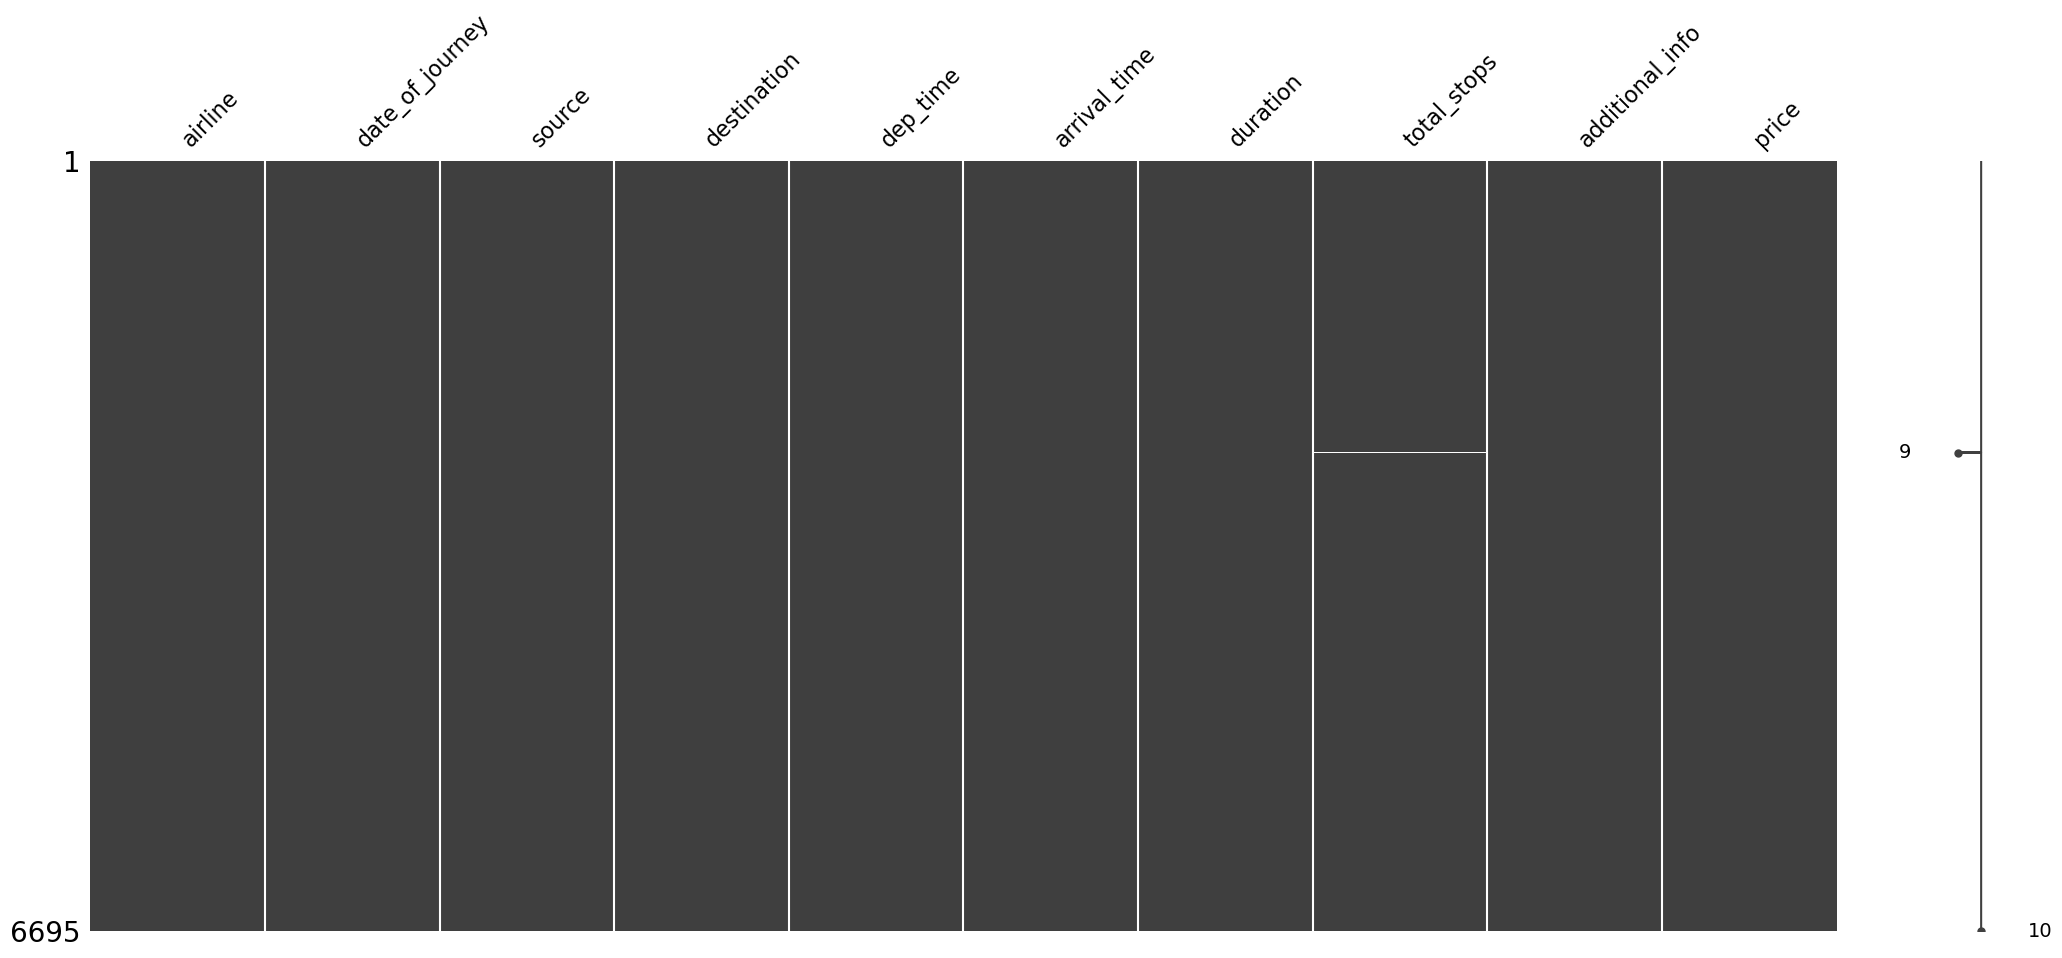

In [11]:
msno.matrix(train)

<Axes: >

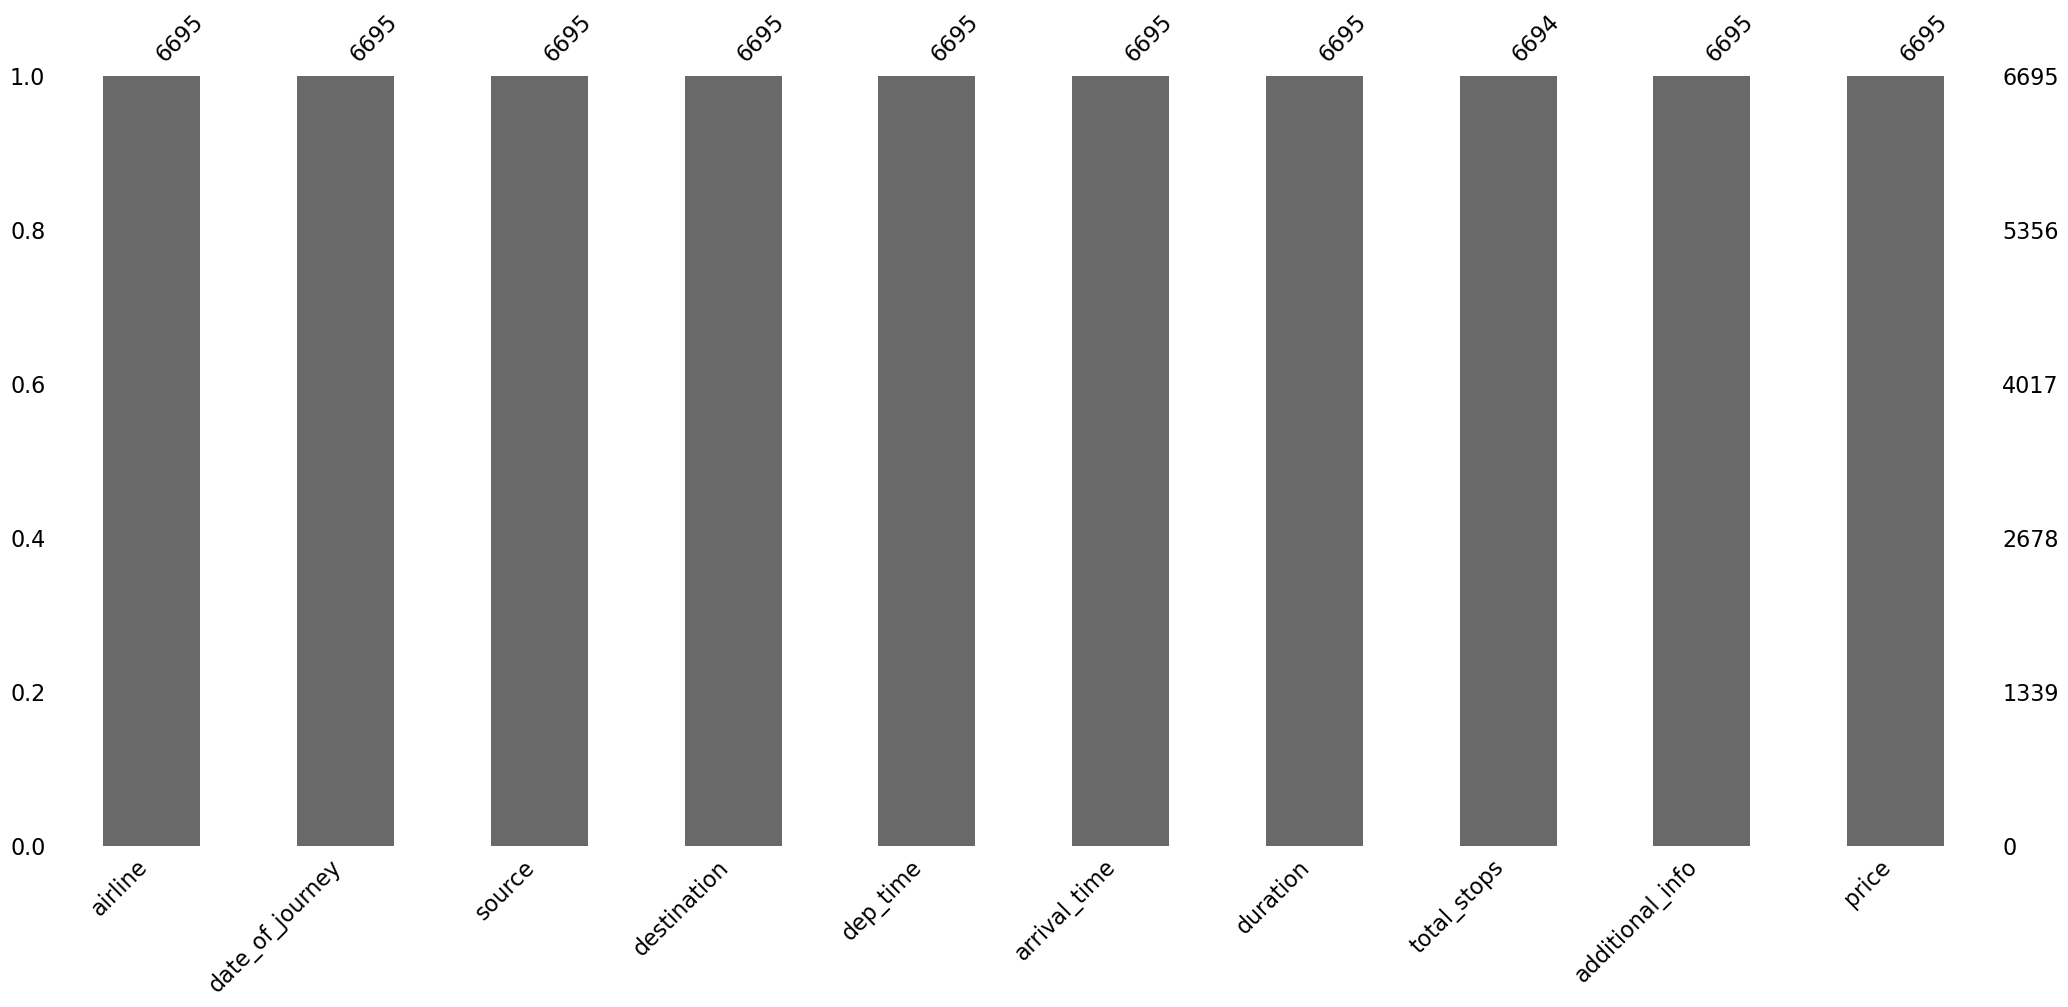

In [12]:
msno.bar(train)

In [13]:
train[(train['airline']=='Air India') & (train['source']=='Delhi') & (train['destination']=='Cochin')]['total_stops'].value_counts()

total_stops
2.0    214
1.0    183
0.0     41
3.0      6
Name: count, dtype: int64

In [14]:
train['total_stops']=train['total_stops'].fillna(2)

In [15]:
train.isna().sum()

airline            0
date_of_journey    0
source             0
destination        0
dep_time           0
arrival_time       0
duration           0
total_stops        0
additional_info    0
price              0
dtype: int64

In [16]:
train['total_stops']=train['total_stops'].astype('object')

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          6695 non-null   object        
 1   date_of_journey  6695 non-null   datetime64[ns]
 2   source           6695 non-null   object        
 3   destination      6695 non-null   object        
 4   dep_time         6695 non-null   datetime64[ns]
 5   arrival_time     6695 non-null   datetime64[ns]
 6   duration         6695 non-null   int64         
 7   total_stops      6695 non-null   object        
 8   additional_info  6695 non-null   object        
 9   price            6695 non-null   int64         
dtypes: datetime64[ns](3), int64(2), object(5)
memory usage: 523.2+ KB


## 5.High-Level Analysis of Outliers

- Isolation Forest (iForest) is an unsupervised machine learning algorithm used primarily for anomaly detection.

#### How Isolation Forest Works:
`Random Subsampling: `
The algorithm first takes a random subset of the data.

`Random Tree Construction: `
It then constructs a random tree by randomly selecting a feature and then randomly selecting a split value between the minimum and maximum values of the selected feature. This process is repeated until:
- All points are isolated (each point is a leaf in the tree).
- A predefined maximum tree height is reached.

`Path Length Calculation:` The length of the path from the root to a leaf (where the data point is isolated) is computed. Anomalies are expected to have shorter paths as they are easier to isolate.

`Anomaly Scoring:` The anomaly score is calculated based on the average path length from multiple trees. A shorter average path length indicates that the data point is likely an anomaly.

In [18]:
forest=IsolationForest(n_estimators=10,random_state=42)

In [19]:
(
    train
    .assign(outlier=forest.fit_predict(train
                                      .drop(columns='price')
                                      .select_dtypes(include='number')))
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
0,Jet Airways,2019-03-21,Banglore,New Delhi,2024-06-12 08:55:00,2024-06-12 19:10:00,615,1.0,In-Flight Meal Not Included,7832,1
1,Jet Airways,2019-03-27,Delhi,Cochin,2024-06-12 17:30:00,2024-06-12 04:25:00,655,1.0,In-Flight Meal Not Included,6540,1
2,Goair,2019-03-09,Banglore,New Delhi,2024-06-12 11:40:00,2024-06-12 14:35:00,175,0.0,No Info,7305,1
3,Air India,2019-06-12,Kolkata,Banglore,2024-06-12 09:25:00,2024-06-12 18:30:00,545,1.0,No Info,8366,1
4,Jet Airways,2019-03-12,Banglore,New Delhi,2024-06-12 22:55:00,2024-06-12 07:40:00,525,1.0,In-Flight Meal Not Included,11087,1
...,...,...,...,...,...,...,...,...,...,...,...
6690,Jet Airways,2019-03-21,Delhi,Cochin,2024-06-12 10:45:00,2024-06-12 18:50:00,1925,2.0,No Info,11093,-1
6691,Air India,2019-05-01,Kolkata,Banglore,2024-06-12 09:25:00,2024-06-12 18:30:00,545,1.0,No Info,8891,1
6692,Jet Airways,2019-06-01,Delhi,Cochin,2024-06-12 14:00:00,2024-06-12 19:00:00,300,1.0,In-Flight Meal Not Included,10262,1
6693,Air Asia,2019-06-24,Delhi,Cochin,2024-06-12 07:55:00,2024-06-12 13:25:00,330,1.0,No Info,6152,-1


In [20]:
(
    train
    .assign(outlier=forest.fit_predict(train
                                      .drop(columns='price')
                                      .select_dtypes(include='number')))
    .query("outlier == -1")
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
5,Jet Airways,2019-04-21,Banglore,Delhi,2024-06-12 18:55:00,2024-06-12 22:00:00,185,0.0,In-Flight Meal Not Included,4544,-1
7,Spicejet,2019-06-15,Mumbai,Hyderabad,2024-06-12 05:45:00,2024-06-12 07:15:00,90,0.0,No Check-In Baggage Included,2647,-1
9,Jet Airways,2019-05-09,Delhi,Cochin,2024-06-12 23:05:00,2024-06-12 04:25:00,1760,2.0,No Info,15129,-1
10,Jet Airways,2019-06-12,Kolkata,Banglore,2024-06-12 14:05:00,2024-06-12 10:05:00,1200,1.0,No Info,13044,-1
12,Jet Airways,2019-06-24,Delhi,Cochin,2024-06-12 21:25:00,2024-06-12 19:00:00,1295,2.0,No Info,13292,-1
...,...,...,...,...,...,...,...,...,...,...,...
6688,Jet Airways,2019-06-15,Delhi,Cochin,2024-06-12 21:25:00,2024-06-12 12:35:00,910,2.0,In-Flight Meal Not Included,9905,-1
6689,Indigo,2019-03-03,Mumbai,Hyderabad,2024-06-12 09:10:00,2024-06-12 10:40:00,90,0.0,No Info,5755,-1
6690,Jet Airways,2019-03-21,Delhi,Cochin,2024-06-12 10:45:00,2024-06-12 18:50:00,1925,2.0,No Info,11093,-1
6693,Air Asia,2019-06-24,Delhi,Cochin,2024-06-12 07:55:00,2024-06-12 13:25:00,330,1.0,No Info,6152,-1


## 6.Pair Plots

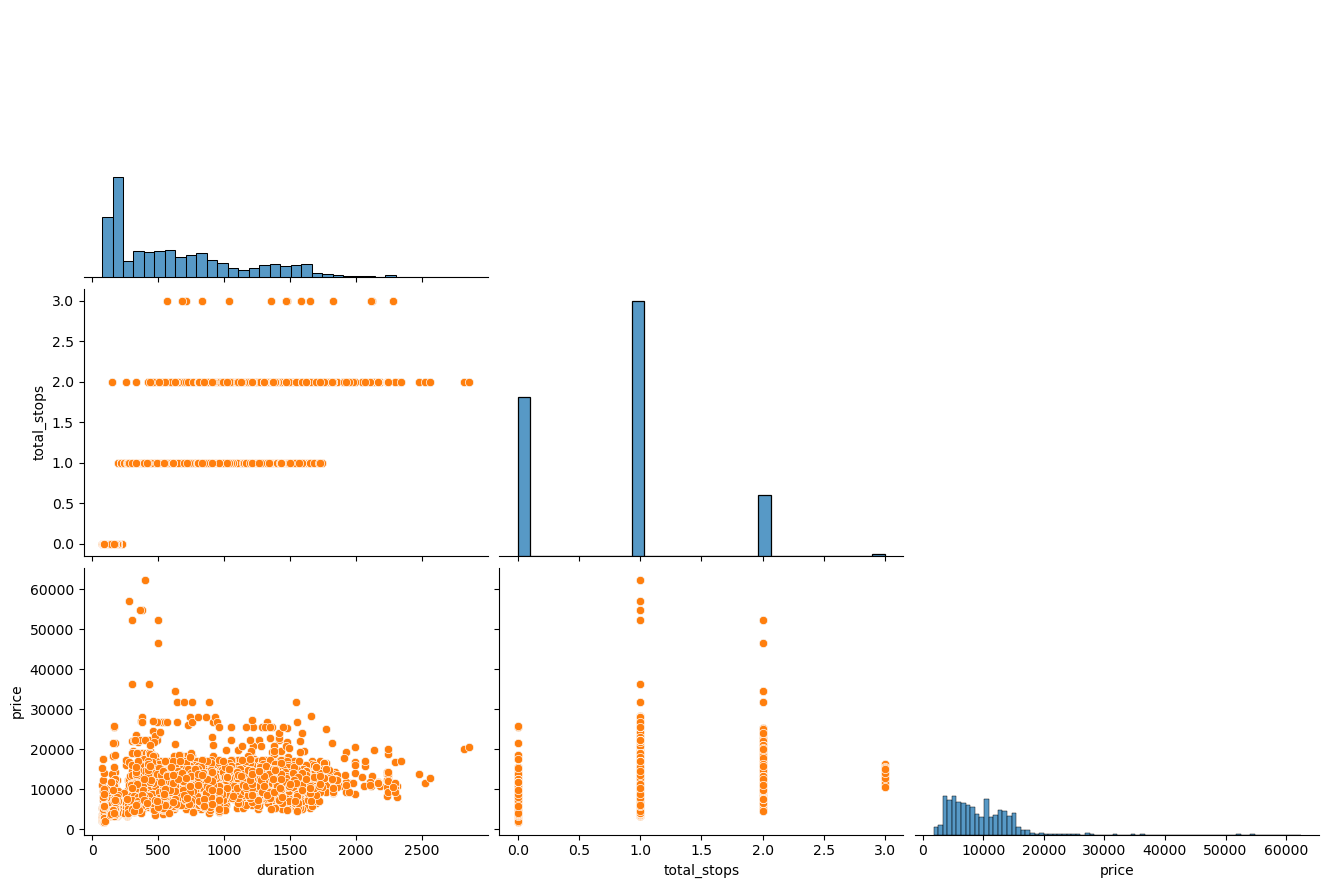

In [21]:
pairgrid=sns.pairplot(data=train,height=3,aspect=1.5,corner=True)
pairgrid.map_lower(sns.scatterplot)

plt.show()

- sort of linear relationship between duration and price i.e.longer the flight more expensive flight ticket.
- there is no much difference between total stop and price.
- for short duration flight there is no stop.
- if flight is longer then there is multiple stops.

## 7.Correlation Analysis

In [22]:
train['total_stops']=train['total_stops'].astype('int')

#eda_helper_functions.correlation_heatmap(train)

cm=train.corr(method='spearman',numeric_only=True)
cm

,duration,total_stops,price
duration,1.000000,0.822928,0.697860
total_stops,0.822928,1.000000,0.720839
price,0.697860,0.720839,1.000000


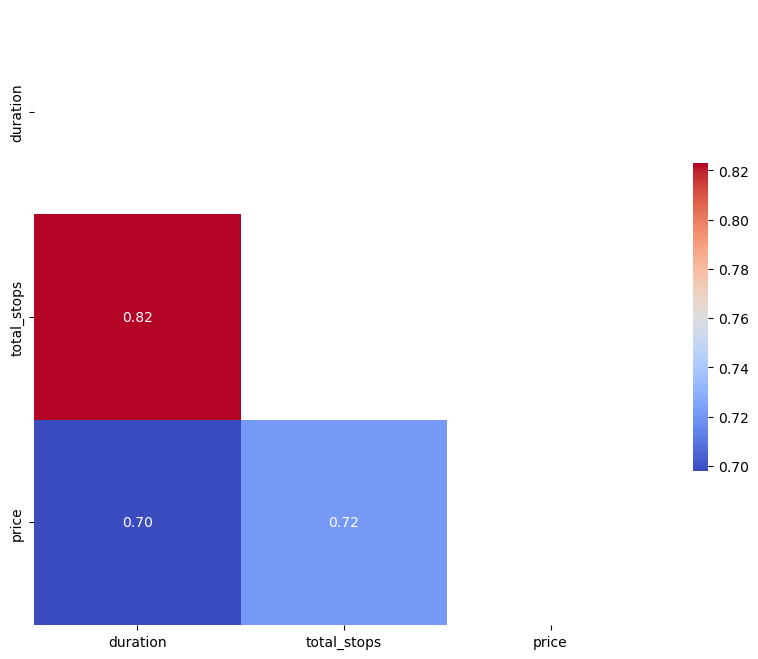

In [23]:
mask = np.triu(np.ones_like(cm, dtype=bool))

plt.figure(figsize=(10, 8))

sns.heatmap(cm, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .5})

plt.show()

## 8.Detailed Analysis

In [24]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

### 8.1 airline

In [25]:
eda_helper_functions.cat_summary(train,'airline')

0       Jet Airways
1       Jet Airways
2             Goair
3         Air India
4       Jet Airways
           ...     
6690    Jet Airways
6691      Air India
6692    Jet Airways
6693       Air Asia
6694      Air India
Name: airline, Length: 6695, dtype: object

Data Type      : object
Cardinality    : 9 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,695 / 6,695 rows


,
count,6695
unique,9
top,Jet Airways
freq,2391


,count,percentage
category,,
Jet Airways,2391,0.357132
Indigo,1296,0.193577
Air India,1076,0.160717
Multiple Carriers,736,0.109933
Spicejet,537,0.080209
Vistara,322,0.048096
Air Asia,211,0.031516
Goair,125,0.018671
Trujet,1,0.000149


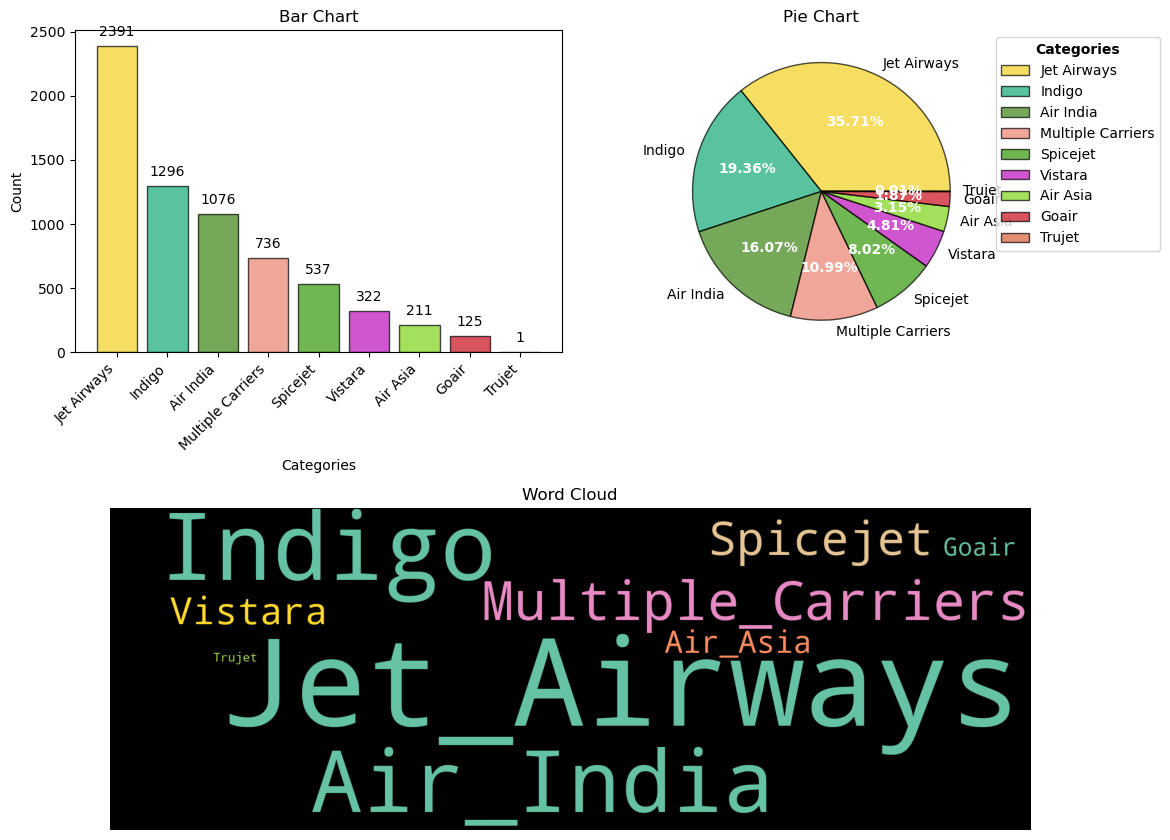

In [26]:
eda_helper_functions.cat_univar_plots(train,'airline')

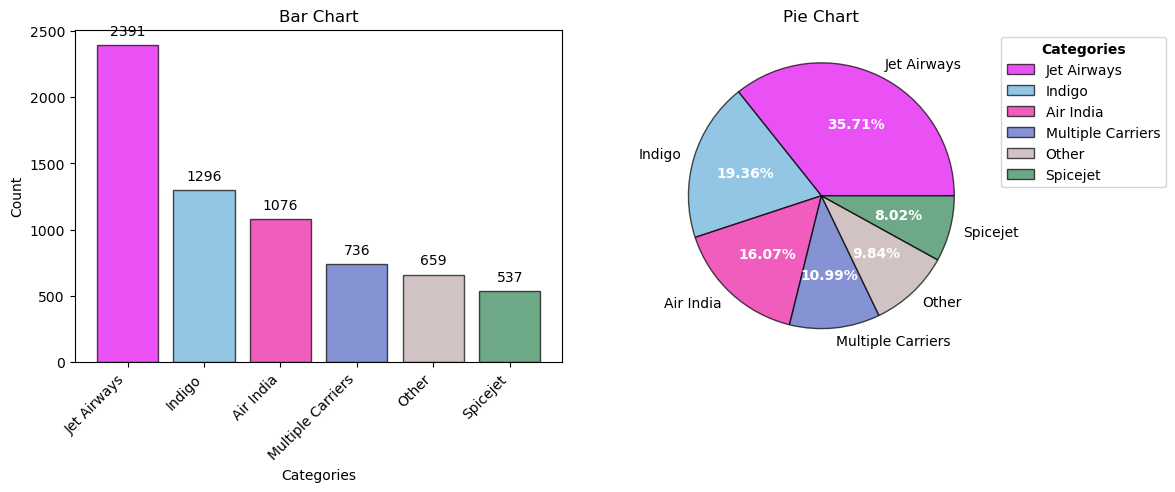

In [27]:
eda_helper_functions.cat_univar_plots(train,'airline',k=5,show_wordcloud=False)   

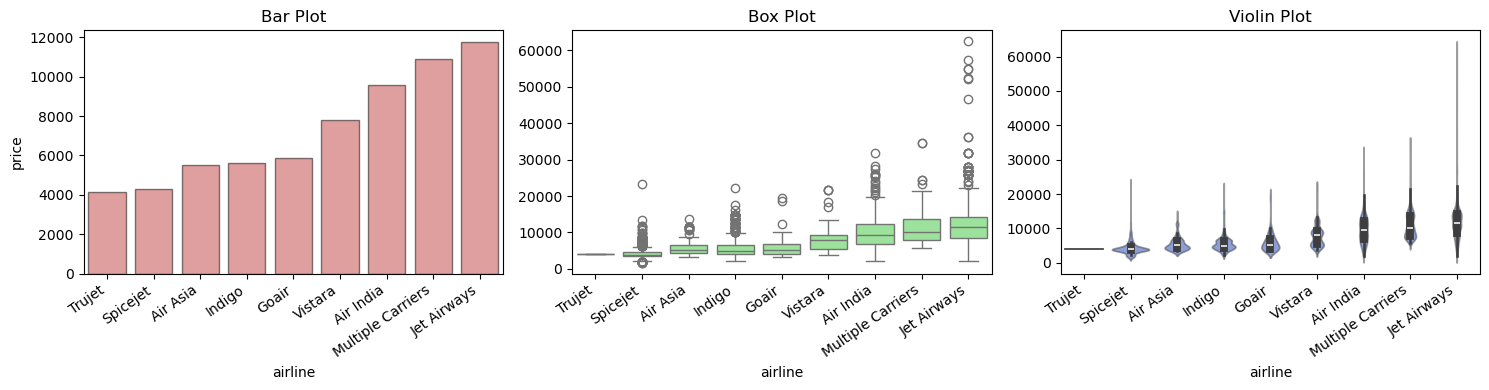

In [28]:
eda_helper_functions.num_cat_bivar_plots(
    data=train,
    num_var='price',
    cat_var='airline'
)

- `Bar plot` it is clearly see that according to airline price vary. so,airline feature is important to predict price. in this we visualize mean value of price.
- `Box plot` in this plot we see the for each category distribution of price.
- `violin plot` in this plot see the distribution shape.

`In the above graph we saw relationship between airline & price so, we want to validate it using hypothesis testing.`

- `One-way ANOVA: If your categorical feature has more than two levels (e.g., different types of fruits), you can use a one-way ANOVA to compare the
  means of the numerical feature across the different groups.`

- `Kruskal-Wallis Test:
If you have more than two groups and your data is not normally distributed, you can use the Kruskal-Wallis test as a non-parametric alternative to ANOVA.`

In [29]:
eda_helper_functions.num_cat_hyp_testing(train,'price','airline')

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 473.280702706463
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 3131.4120748217883
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


In [30]:
df=train.dropna(subset=['price']).groupby('airline')

groups=[grp['price'].values  for _,grp in df]

In [31]:
from scipy.stats import f_oneway

stat,p_val=f_oneway(*groups)
print(stat,'  ',p_val)

473.280702706463    0.0


`CONCLUSION : 
`An F-statistic of 473.280702706463 is extremely large, indicating that the between-group variance is much greater than the within-group variance. This leads to a very small p-value, suggesting strong evidence against the null hypothesis

In [32]:
from scipy.stats import kruskal

stat,p_val=kruskal(*groups)
print(stat,'  ',p_val)

3131.4120748217883    0.0


`CONCLUSION : `A p-value of 0.0 from the Kruskal-Wallis test signifies that there is a statistically significant difference between the distributions of the groups with very high confidence. This result suggests you should reject the null hypothesis, indicating that at least one group distribution is different from the others.

### Multivariate Analysis between airline & price

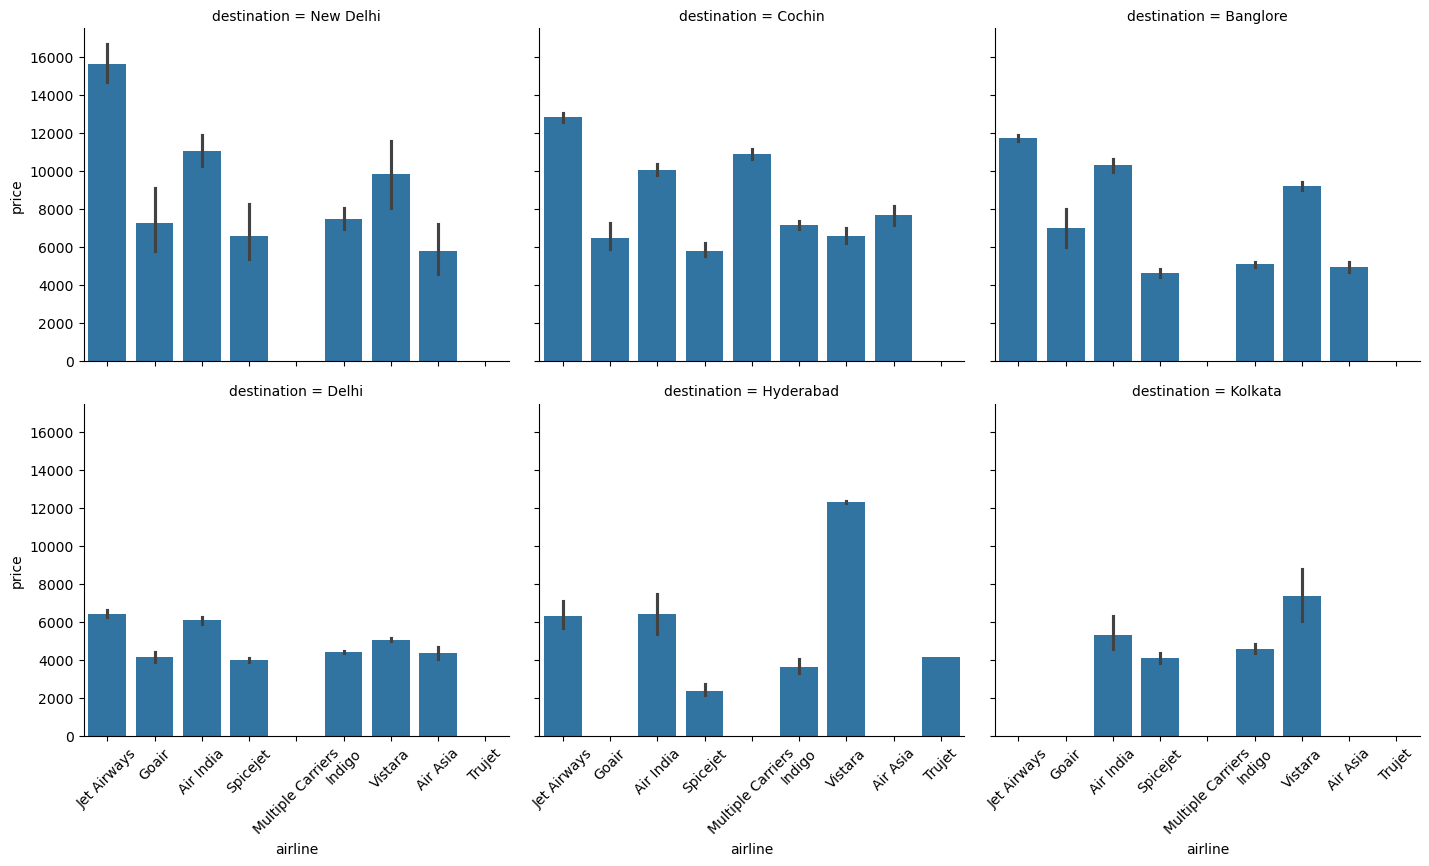

In [33]:
airline_grid = sns.FacetGrid(
    data=train,
    col='destination',
    col_wrap=3,
    height=4,
    aspect=1.2,
    sharey=True
)


airline_grid.map(
    sns.barplot,
    'airline',
    'price',
     order=train.airline.unique()
)

for ax in airline_grid.axes[3:]:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [34]:
train.groupby(['destination','airline'])['price'].mean().to_frame()

price
destination airline                        
Banglore    Air Asia            4919.273684
            Air India          10268.896226
            Goair               7004.421053
            Indigo              5076.500000
            Jet Airways        11703.753408
            Spicejet            4627.452736
            Vistara             9179.827869
Cochin      Air Asia            7653.153846
            Air India          10040.959551
            Goair               6452.458333
            Indigo              7126.492239
            Jet Airways        12796.286805
            Multiple Carriers  10877.110054
            Spicejet            5794.340000
            Vistara             6536.064516
Delhi       Air Asia            4357.600000
            Air India           6079.794872
            Goair               4133.975610
            Indigo              4398.646288
            Jet Airways         6434.531120
            Spicejet            4003.271845
            Vistara             5047.106383
Hyderabad   Air India           6396.045455
            Indigo              3614.700000
            Jet Airways         6329.977444
            Spicejet            2365.312500
            Trujet              4140.000000
            Vistara            12316.250000
Kolkata     Air India           5303.687500
            Indigo              4580.478992
            Spicejet            4079.064935
            Vistara             7351.785714
New Delhi   Air Asia            5757.642857
            Air India          11028.389313
            Goair               7268.294118
            Indigo              7444.655172
            Jet Airways        15583.423208
            Spicejet            6536.038462
            Vistara             9811.935484

`CONCLUSION`
- It is plot between the airline & price variables on the basis of destination.

`Destination: Banglore`
- Most Expensive Airline: Jet Airways (₹11,703.75)
- Least Expensive Airline: Spicejet (₹4,627.45)
- Mid-Range Airlines: Air India, Vistara, Goair, Indigo, Air Asia

`Destination: Cochin`
- Most Expensive Airline: Jet Airways (₹12,796.29)
- Least Expensive Airline: Spicejet (₹5,794.34)
- Mid-Range Airlines: Multiple Carriers, Air India, Vistara, Indigo, Air Asia, Goair

`Destination: Delhi`
- Most Expensive Airline: Jet Airways (₹6,434.53)
- Least Expensive Airline: Spicejet (₹4,003.27)
- Mid-Range Airlines: Air India, Vistara, Indigo, Air Asia, Goair

`Destination: Hyderabad`
- Most Expensive Airline: Vistara (₹12,316.25)
- Least Expensive Airline: Spicejet (₹2,365.31)
- Mid-Range Airlines: Air India, Jet Airways, Trujet, Indigo

`Destination: Kolkata`
- Most Expensive Airline: Vistara (₹7,351.79)
- Least Expensive Airline: Spicejet (₹4,079.06)
- Mid-Range Airlines: Air India, Indigo

`Destination: New Delhi`
- Most Expensive Airline: Jet Airways (₹15,583.42)
- Least Expensive Airline: Air Asia (₹5,757.64)
- Mid-Range Airlines: Air India, Vistara, Indigo, Goair, Spicejet

`General Observations`
- Jet Airways tends to be the most expensive airline across most destinations.
- Spicejet generally offers the least expensive flights across multiple destinations.
- Vistara and Air India are often among the more expensive options, though not always the most expensive.
- Indigo and Air Asia usually offer mid-range prices but are consistently cheaper than Jet Airways and sometimes Air India and Vistara.

### 8.2 date_of_journey

In [35]:
train.date_of_journey

0      2019-03-21
1      2019-03-27
2      2019-03-09
3      2019-06-12
4      2019-03-12
          ...    
6690   2019-03-21
6691   2019-05-01
6692   2019-06-01
6693   2019-06-24
6694   2019-03-01
Name: date_of_journey, Length: 6695, dtype: datetime64[ns]

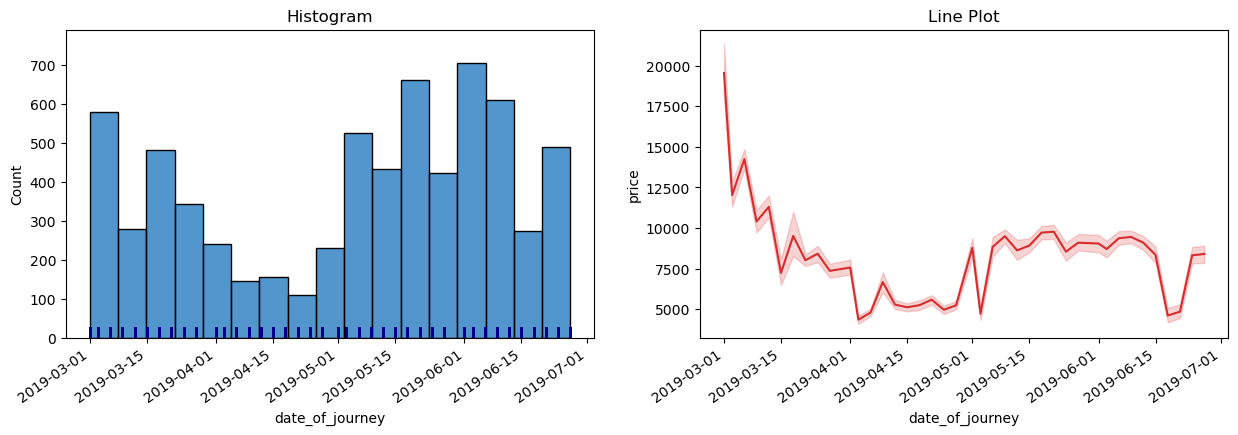

In [36]:
eda_helper_functions.dt_univar_plots(
    data=train,
    var='date_of_journey',
    target='price'
)

In [37]:
(
    train
    .groupby(pd.Grouper(key='date_of_journey',freq='M'))
    .price.mean()
    .to_frame()
    .set_axis(['March','April','May','June'],axis=0)
    .rename_axis(index='month')
)

,price
month,
March,10808.167558
April,5827.549790
May,9090.468891
June,8627.806824


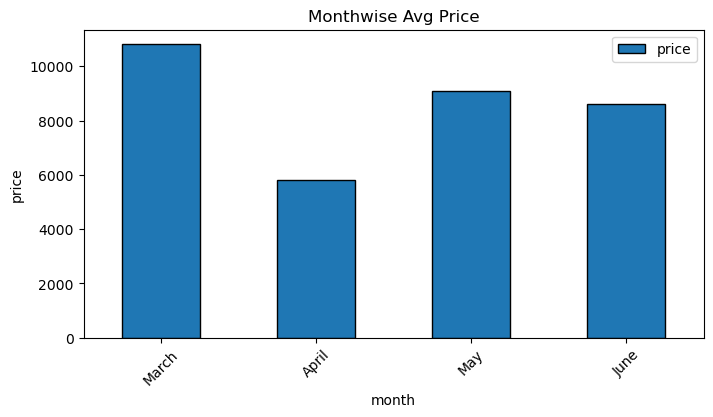

In [38]:
temp_df=(
    train
    .groupby(pd.Grouper(key='date_of_journey',freq='M'))
    .price.mean()
    .to_frame()
    .set_axis(['March','April','May','June'],axis=0)
    .rename_axis(index='month')
    
)


ax = temp_df.plot(kind='bar',figsize=(8,4),edgecolor='black')

plt.title('Monthwise Avg Price')
plt.ylabel('price')
plt.xticks(rotation=45)
plt.show()

In [39]:
(
    train
    .groupby(pd.Grouper(key='date_of_journey',freq='W'))
    .price.mean()
    .to_frame()
    .rename_axis(index='week')
    
)


,price
week,
2019-03-03,15138.589905
2019-03-10,12652.227679
2019-03-17,9159.432161
2019-03-24,8435.934513
2019-03-31,7363.538961
2019-04-07,6229.612378
2019-04-14,6158.015504
2019-04-21,5313.740741
2019-04-28,5107.321739


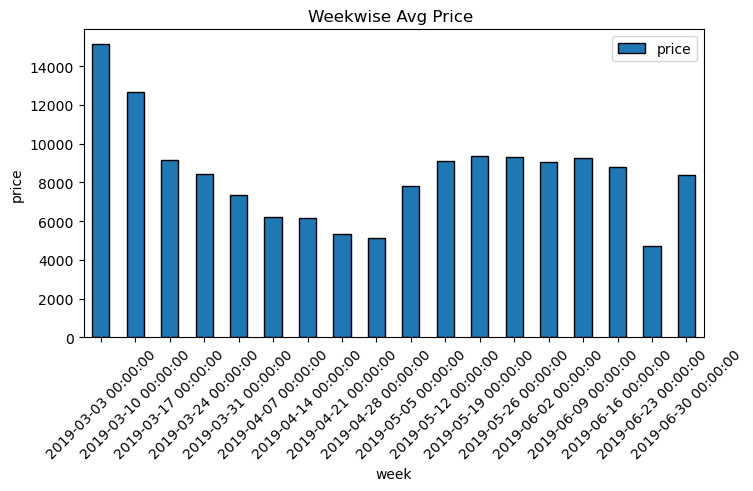

In [40]:
temp_df=(
    train
    .groupby(pd.Grouper(key='date_of_journey',freq='W'))
    .price.mean()
    .to_frame()
    .rename_axis(index='week')
    
)

ax = temp_df.plot(kind='bar',figsize=(8,4),edgecolor='black')

plt.title('Weekwise Avg Price ')
plt.ylabel('price')
plt.xticks(rotation=45)
plt.show()

In [41]:
(
    train
    .groupby([pd.Grouper(key='date_of_journey',freq='M'),'source'])
    .price.mean()
    .unstack(fill_value=0)
    .set_axis(['March','April','May','June'],axis=0)
    .rename_axis(index='month')
)

source,Banglore,Chennai,Delhi,Kolkata,Mumbai
month,,,,,
March,12248.116861,5745.760000,11676.004615,7871.908654,7919.417219
April,5156.727586,0.000000,6435.993590,6456.781893,3607.458333
May,4847.735507,4316.474359,10640.902010,10186.477103,3509.612403
June,5455.362963,4393.758621,10246.865248,8873.612832,3680.027778


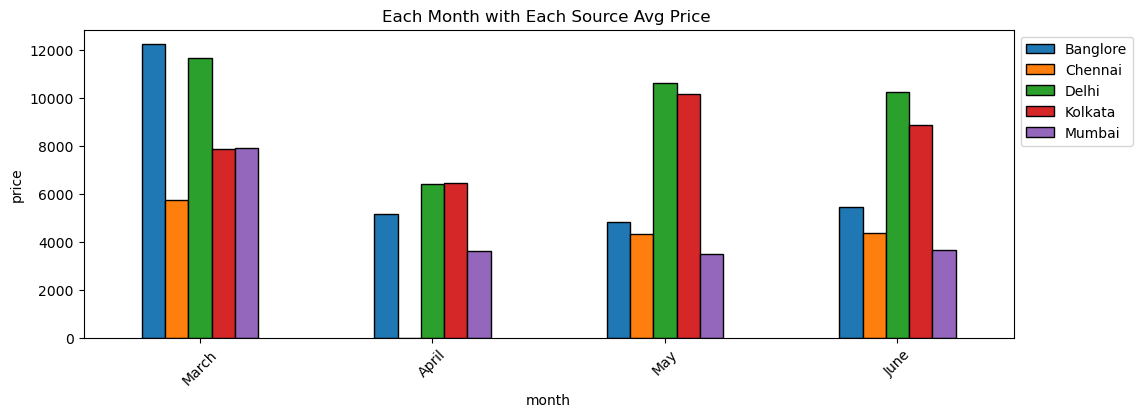

In [42]:
temp_df=(
    train
    .groupby([pd.Grouper(key='date_of_journey',freq='M'),'source'])
    .price.mean()
    .unstack(fill_value=0)
    .set_axis(['March','April','May','June'],axis=0)
    .rename_axis(index='month')
)

ax = temp_df.plot(kind='bar',figsize=(12,4),edgecolor='black')

plt.title('Each Month with Each Source Avg Price ')
plt.ylabel('price')
plt.xticks(rotation=45)
plt.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.show()

`CONCLUSION : `

`Bangalore:` The ticket prices in March are significantly higher than in the subsequent months. The lowest prices are observed in April and May.

`Chennai:` April shows a ticket price of 0, which is likely a data entry error or indicates no flights were recorded. May and June prices are relatively stable and much lower than March.

`Delhi:` There is a peak in March, a drop in April, and then a slight rise in May, with a slight decrease again in June.

`Kolkata:` Prices are highest in March and decrease progressively in the following months, reaching the lowest in May and June.

`Mumbai:` Similar to other cities, prices are highest in March and then significantly lower in the following months.


### 8.3 source

In [43]:
eda_helper_functions.cat_summary(train,'source')

0       Banglore
1          Delhi
2       Banglore
3        Kolkata
4       Banglore
          ...   
6690       Delhi
6691     Kolkata
6692       Delhi
6693       Delhi
6694    Banglore
Name: source, Length: 6695, dtype: object

Data Type      : object
Cardinality    : 5 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,695 / 6,695 rows


,
count,6695
unique,5
top,Delhi
freq,2730


,count,percentage
category,,
Delhi,2730,0.407767
Kolkata,1842,0.275131
Banglore,1435,0.214339
Mumbai,448,0.066916
Chennai,240,0.035848


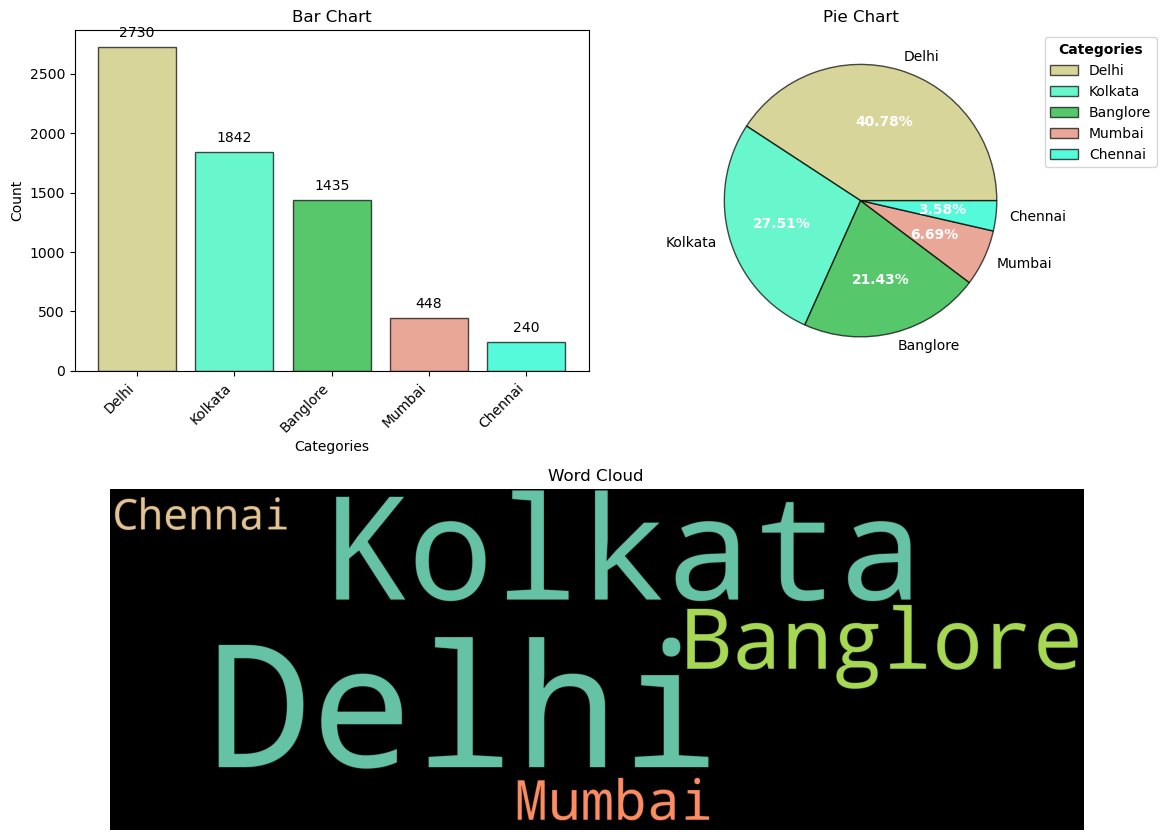

In [44]:
eda_helper_functions.cat_univar_plots(train,'source')

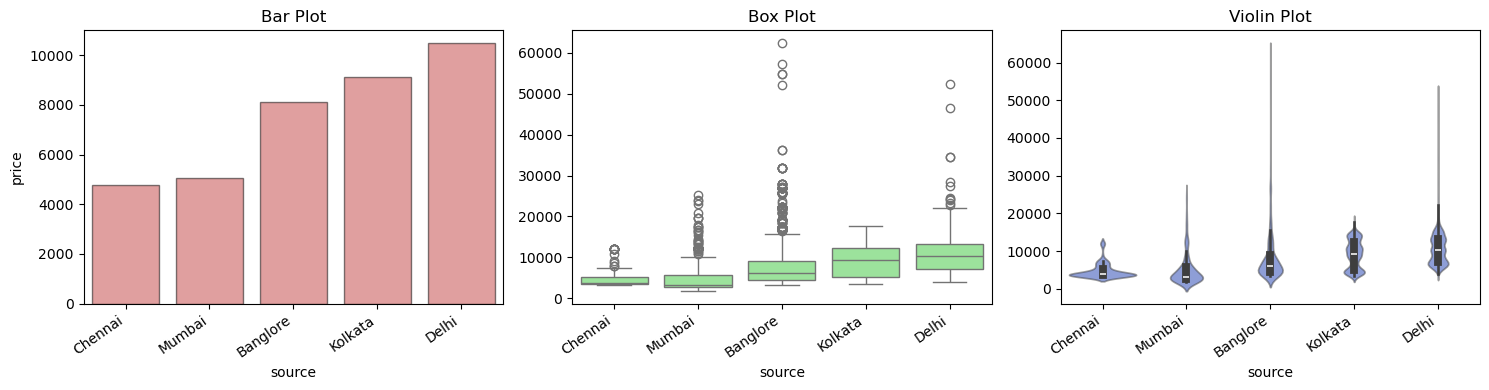

In [45]:
eda_helper_functions.num_cat_bivar_plots(
    data=train,
    num_var='price',
    cat_var='source'
)

In [46]:
eda_helper_functions.num_cat_hyp_testing(train,'price','source')

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 244.51116860534717
- p-value              : 2.578390293716684e-196
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and source are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 1425.3410389278386
- p-value              : 2.211178173713932e-307
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and source are associated to each other


### 8.4 destination

In [47]:
eda_helper_functions.cat_summary(train,'destination')

0       New Delhi
1          Cochin
2       New Delhi
3        Banglore
4       New Delhi
          ...    
6690       Cochin
6691     Banglore
6692       Cochin
6693       Cochin
6694    New Delhi
Name: destination, Length: 6695, dtype: object

Data Type      : object
Cardinality    : 6 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,695 / 6,695 rows


,
count,6695
unique,6
top,Cochin
freq,2730


,count,percentage
category,,
Cochin,2730,0.407767
Banglore,1842,0.275131
Delhi,836,0.124869
New Delhi,599,0.089470
Hyderabad,448,0.066916
Kolkata,240,0.035848


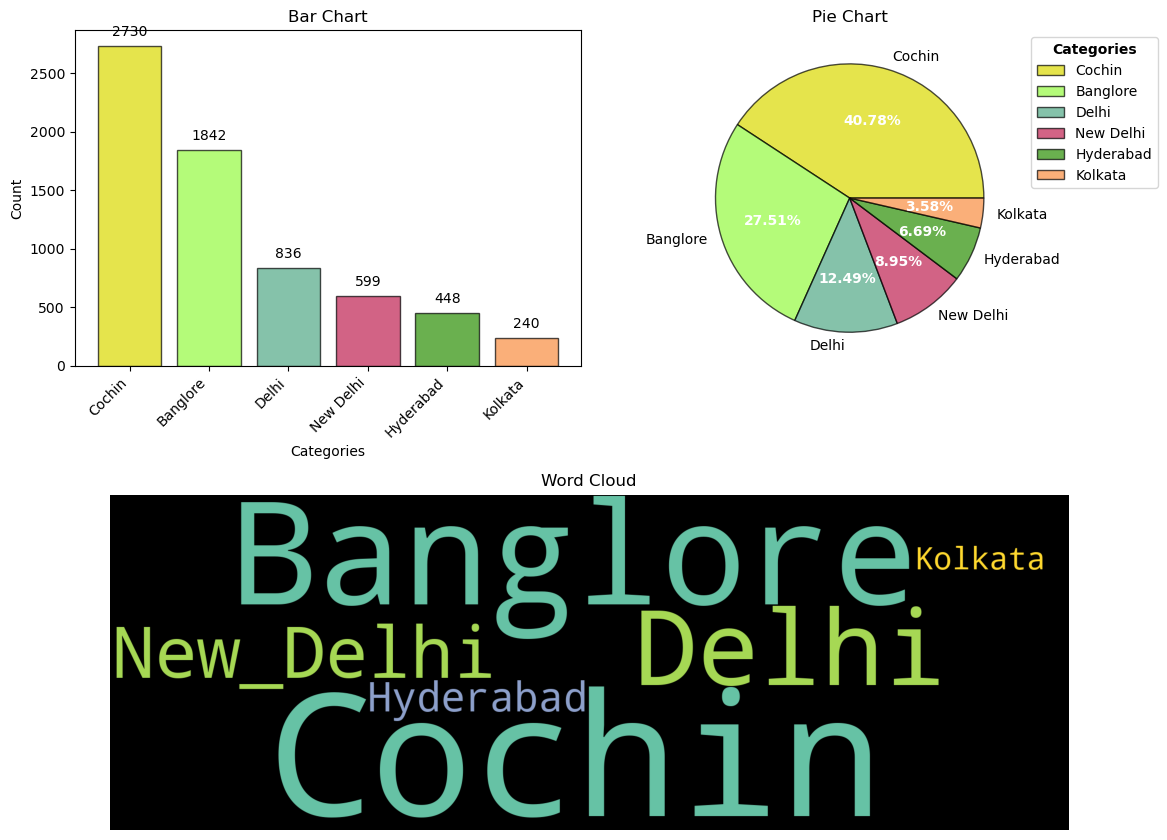

In [48]:
eda_helper_functions.cat_univar_plots(train,'destination')

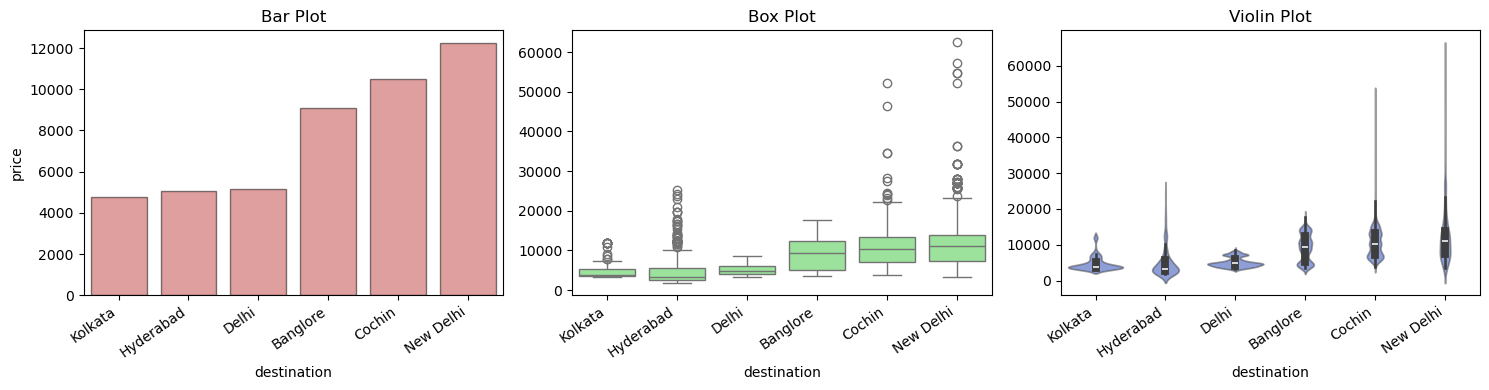

In [49]:
eda_helper_functions.num_cat_bivar_plots(
    data=train,
    num_var='price',
    cat_var='destination'
)

In [50]:
eda_helper_functions.num_cat_hyp_testing(train,'price','destination')

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 444.81438403541205
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and destination are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 2144.685992140532
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and destination are associated to each other


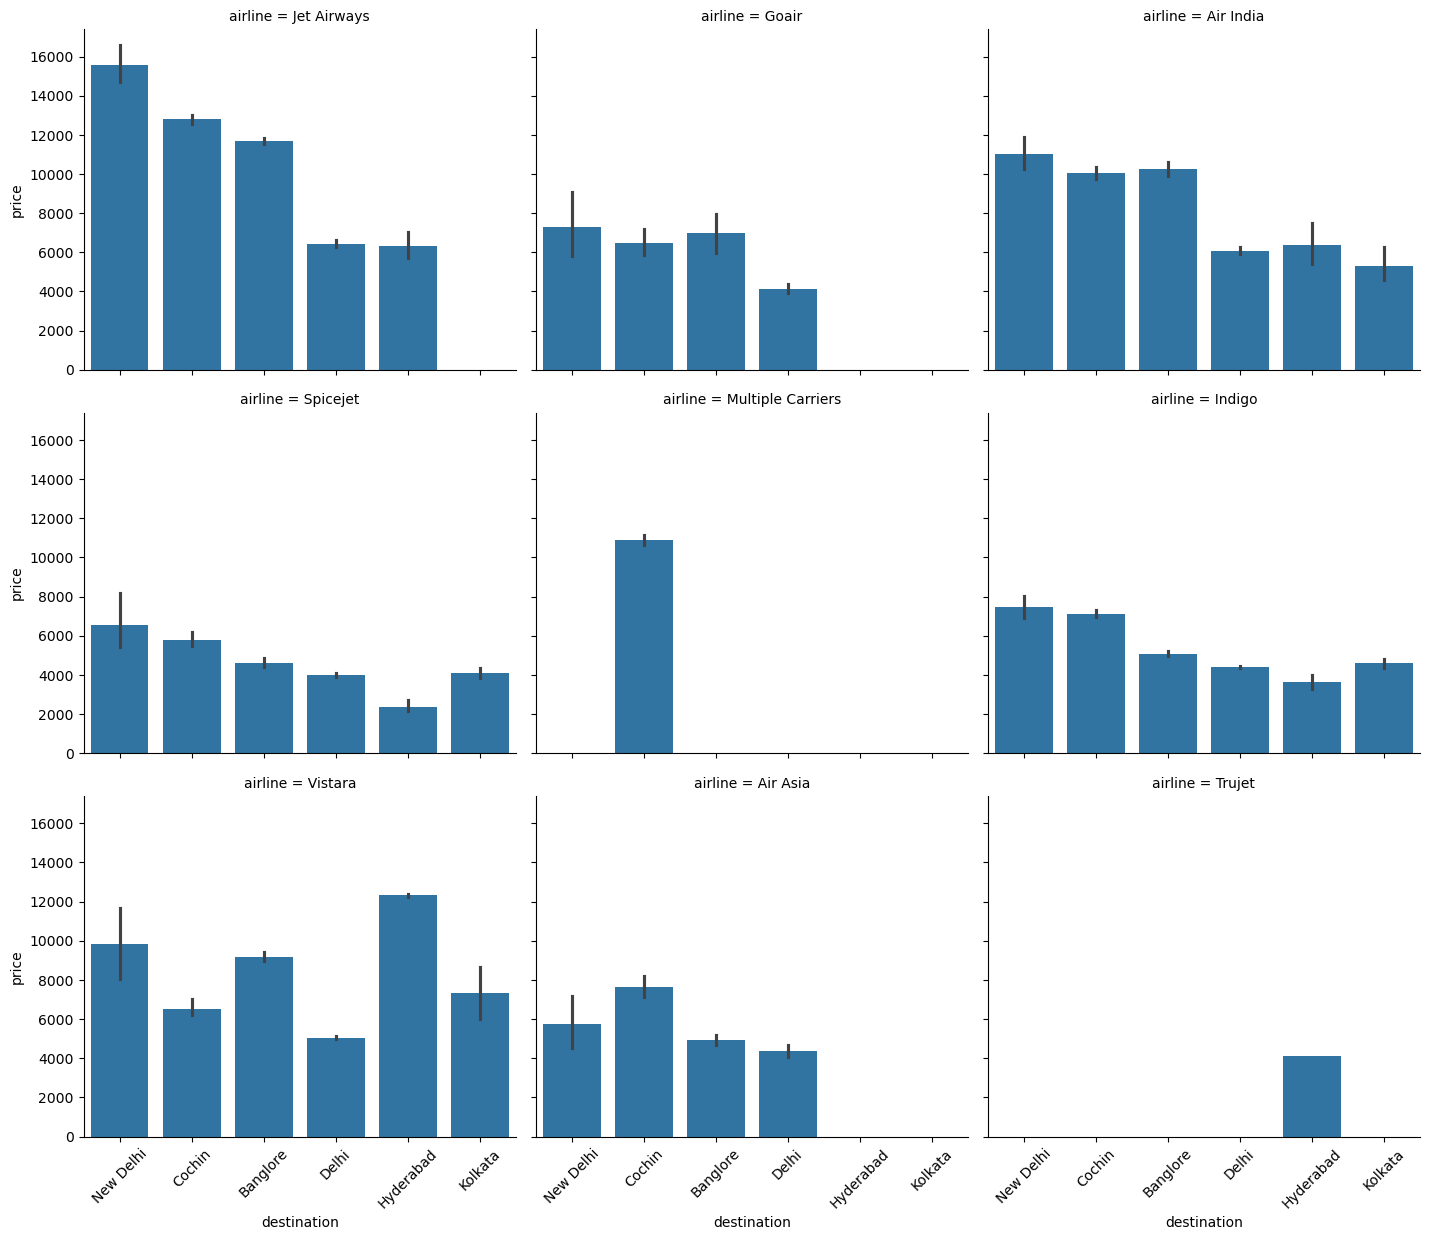

In [51]:
airline_grid = sns.FacetGrid(
    data=train,
    col='airline',
    col_wrap=3,
    height=4,
    aspect=1.2,
    sharey=True
)


airline_grid.map(
    sns.barplot,
    'destination',
    'price',
     order=train.destination.unique()
)

for ax in airline_grid.axes[6:]:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [52]:
train.groupby(['airline','source','destination'])['price'].mean().to_frame()

price
airline           source   destination              
Air Asia          Banglore Delhi         4357.600000
                           New Delhi     5757.642857
                  Delhi    Cochin        7653.153846
                  Kolkata  Banglore      4919.273684
Air India         Banglore Delhi         6079.794872
                           New Delhi    11028.389313
                  Chennai  Kolkata       5303.687500
                  Delhi    Cochin       10040.959551
                  Kolkata  Banglore     10268.896226
                  Mumbai   Hyderabad     6396.045455
Goair             Banglore Delhi         4133.975610
                           New Delhi     7268.294118
                  Delhi    Cochin        6452.458333
                  Kolkata  Banglore      7004.421053
Indigo            Banglore Delhi         4398.646288
                           New Delhi     7444.655172
                  Chennai  Kolkata       4580.478992
                  Delhi    Cochin        7126.492239
                  Kolkata  Banglore      5076.500000
                  Mumbai   Hyderabad     3614.700000
Jet Airways       Banglore Delhi         6434.531120
                           New Delhi    15583.423208
                  Delhi    Cochin       12796.286805
                  Kolkata  Banglore     11703.753408
                  Mumbai   Hyderabad     6329.977444
Multiple Carriers Delhi    Cochin       10877.110054
Spicejet          Banglore Delhi         4003.271845
                           New Delhi     6536.038462
                  Chennai  Kolkata       4079.064935
                  Delhi    Cochin        5794.340000
                  Kolkata  Banglore      4627.452736
                  Mumbai   Hyderabad     2365.312500
Trujet            Mumbai   Hyderabad     4140.000000
Vistara           Banglore Delhi         5047.106383
                           New Delhi     9811.935484
                  Chennai  Kolkata       7351.785714
                  Delhi    Cochin        6536.064516
                  Kolkata  Banglore      9179.827869
                  Mumbai   Hyderabad    12316.250000

`CONCLUSION : `

`Airline with Widest Range of Prices:`
Jet Airways: Prices range significantly higher compared to other airlines.

`Cheapest Overall Airline:`
Spicejet consistently offers the lowest prices on most routes.

### 8.5 dep_time

In [53]:
train.dep_time

0      2024-06-12 08:55:00
1      2024-06-12 17:30:00
2      2024-06-12 11:40:00
3      2024-06-12 09:25:00
4      2024-06-12 22:55:00
               ...        
6690   2024-06-12 10:45:00
6691   2024-06-12 09:25:00
6692   2024-06-12 14:00:00
6693   2024-06-12 07:55:00
6694   2024-06-12 11:50:00
Name: dep_time, Length: 6695, dtype: datetime64[ns]

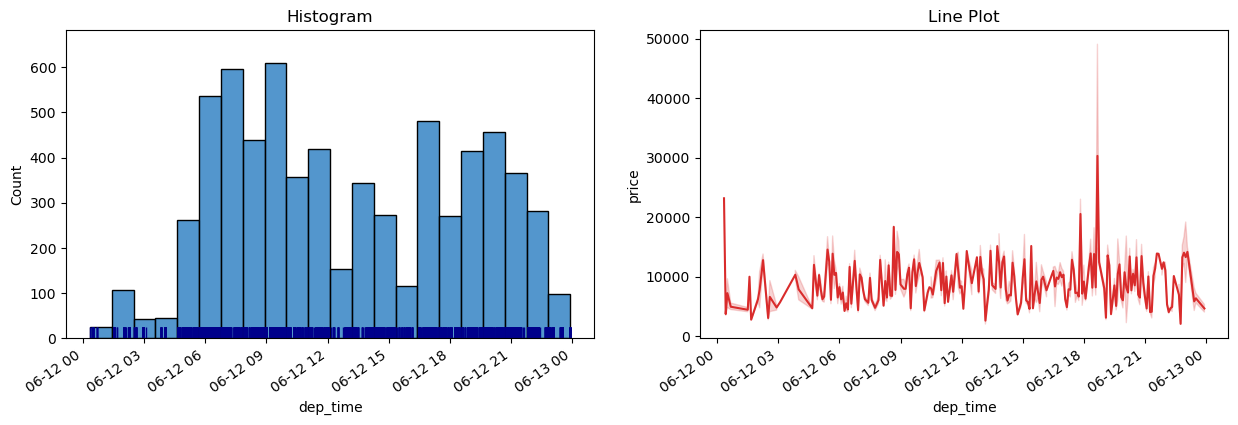

In [54]:
eda_helper_functions.dt_univar_plots(train,'dep_time','price')

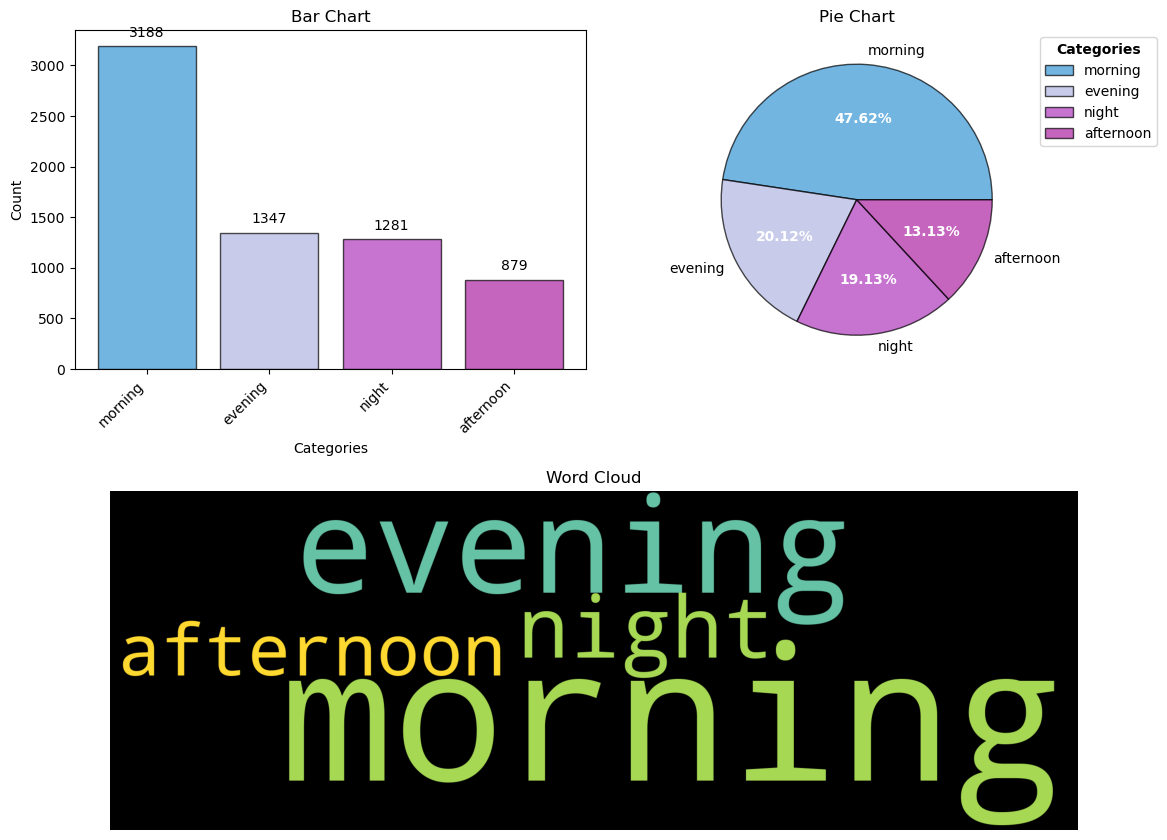

In [55]:
# convert into categories

(
    train
    .assign(dep_time = lambda df_ : (
                        np.select([df_.dep_time.dt.hour.between(4,12,inclusive='left'),
                                   df_.dep_time.dt.hour.between(12,16,inclusive='left'),
                                   df_.dep_time.dt.hour.between(16,20,inclusive='left')],
                                    ['morning','afternoon','evening'],
                                    default='night')
    ))
    .pipe(eda_helper_functions.cat_univar_plots,'dep_time')
)
# np.select([condition],[choice],default)

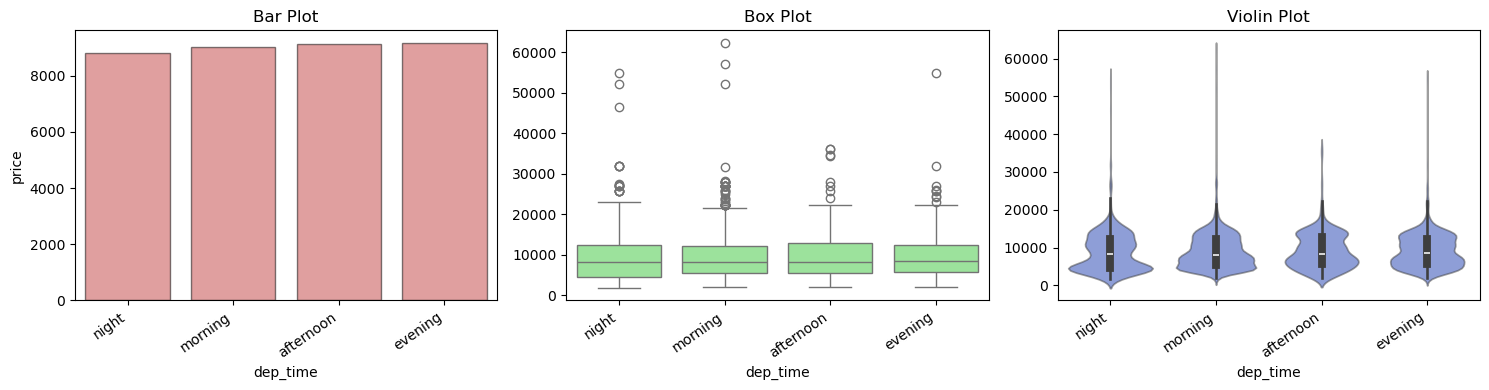

In [56]:
(
    train
    .assign(dep_time = lambda df_ : (
                        np.select([df_.dep_time.dt.hour.between(4,12,inclusive='left'),
                                   df_.dep_time.dt.hour.between(12,16,inclusive='left'),
                                   df_.dep_time.dt.hour.between(16,20,inclusive='left')],
                                    ['morning','afternoon','evening'],
                                    default='night')
    ))
    .pipe(eda_helper_functions.num_cat_bivar_plots,'price','dep_time')
)

`CONCLUSION :`
- Evening flights are the most expensive on average.
- Night flights are the least expensive.
- Morning and afternoon flights have intermediate prices, with morning flights being slightly cheaper than afternoon flights.

### 8.6 arrival_time

In [57]:
train.arrival_time

0      2024-06-12 19:10:00
1      2024-06-12 04:25:00
2      2024-06-12 14:35:00
3      2024-06-12 18:30:00
4      2024-06-12 07:40:00
               ...        
6690   2024-06-12 18:50:00
6691   2024-06-12 18:30:00
6692   2024-06-12 19:00:00
6693   2024-06-12 13:25:00
6694   2024-06-12 08:55:00
Name: arrival_time, Length: 6695, dtype: datetime64[ns]

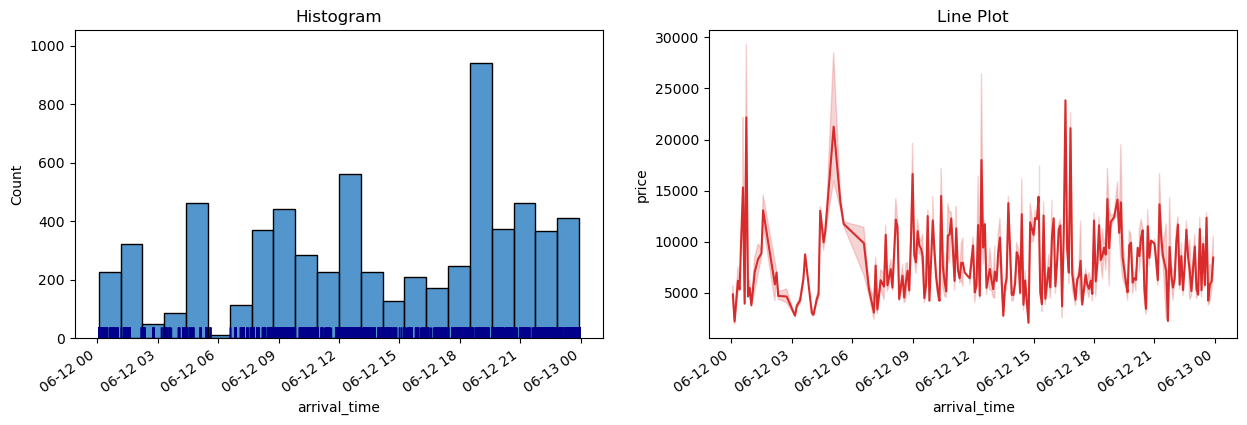

In [58]:
eda_helper_functions.dt_univar_plots(train,'arrival_time','price')

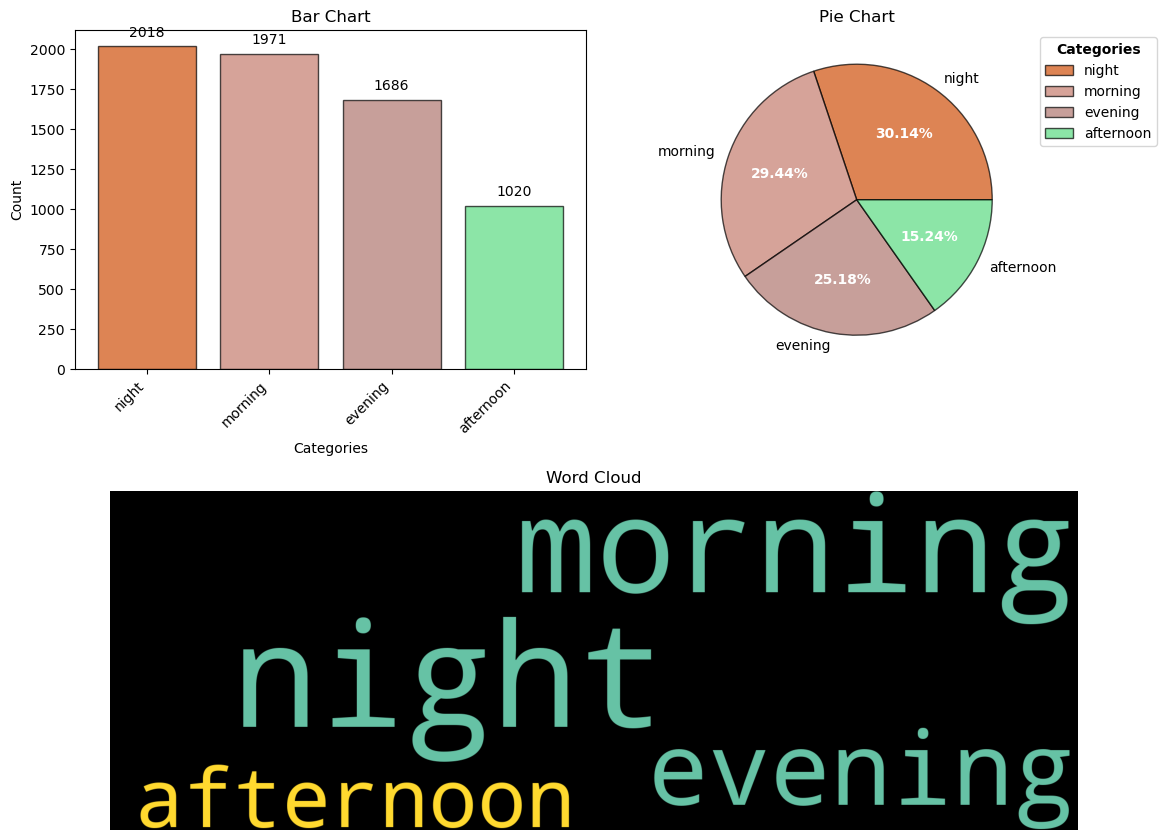

In [59]:
# convert into categories

(
    train
    .assign(arrival_time = lambda df_ : (
                        np.select([df_.arrival_time.dt.hour.between(4,12,inclusive='left'),
                                   df_.arrival_time.dt.hour.between(12,16,inclusive='left'),
                                   df_.arrival_time.dt.hour.between(16,20,inclusive='left')],
                                    ['morning','afternoon','evening'],
                                    default='night')
    ))
    .pipe(eda_helper_functions.cat_univar_plots,'arrival_time')
)

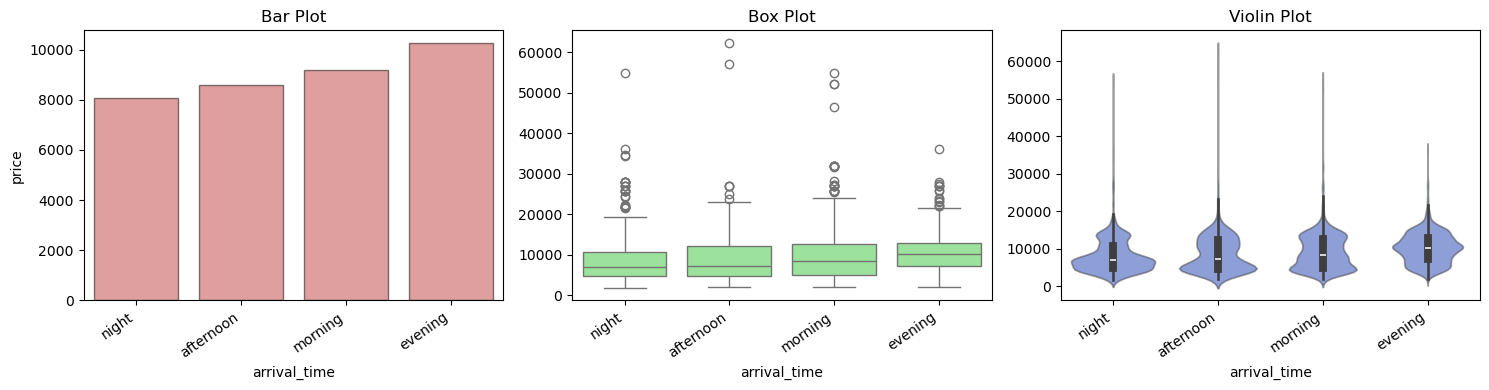

In [60]:
(
    train
    .assign(arrival_time = lambda df_ : (
                        np.select([df_.arrival_time.dt.hour.between(4,12,inclusive='left'),
                                   df_.arrival_time.dt.hour.between(12,16,inclusive='left'),
                                   df_.arrival_time.dt.hour.between(16,20,inclusive='left')],
                                    ['morning','afternoon','evening'],
                                    default='night')
    ))
    .pipe(eda_helper_functions.num_cat_bivar_plots,'price','arrival_time')
)

`CONCLUSION :`
- Evening flights are the most expensive on average.
- Night flights are the least expensive.
- Morning and afternoon flights have intermediate prices.


### 8.7 duration

In [61]:
train.duration

0        615
1        655
2        175
3        545
4        525
        ... 
6690    1925
6691     545
6692     300
6693     330
6694    1265
Name: duration, Length: 6695, dtype: int64

In [62]:
eda_helper_functions.num_summary(train,'duration')

0        615
1        655
2        175
3        545
4        525
        ... 
6690    1925
6691     545
6692     300
6693     330
6694    1265
Name: duration, Length: 6695, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 6,695 / 6,695 rows


,value
percentile,
0,75.0
5,90.0
10,145.0
25,170.0
50,510.0
75,922.5
90,1440.0
95,1601.5
99,1855.0


,value
mean,633.489171
trimmed mean (5%),599.711299
trimmed mean (10%),571.053761
median,510.000000


,value
var,253015.348516
std,503.006311
IQR,752.500000
mad,340.000000
coef_variance,0.794025


,value
skewness,0.893578
kurtosis,-0.053860


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 0.0
Test Statistic       : 0.8865603804588318
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.787
Test Statistic       : 248.46369663341648
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


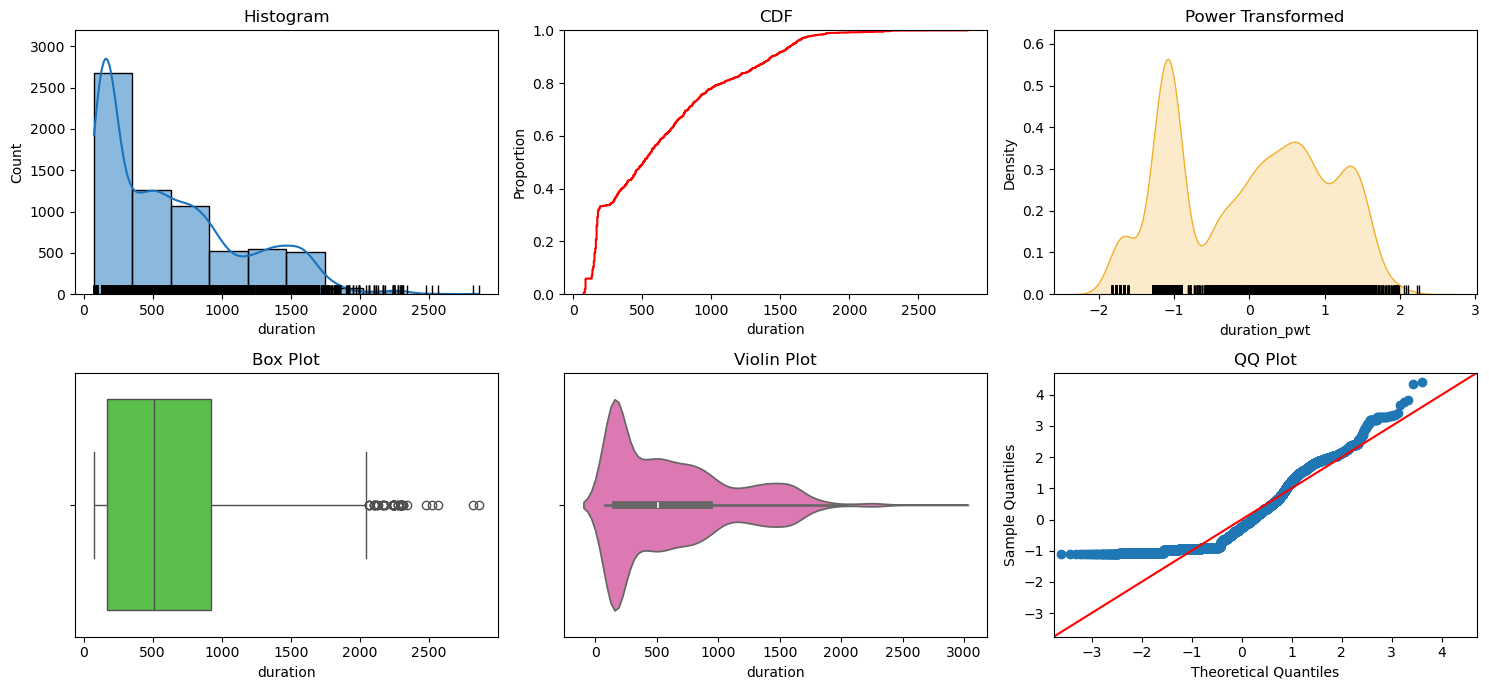

In [63]:
eda_helper_functions.num_univar_plots(train,'duration')

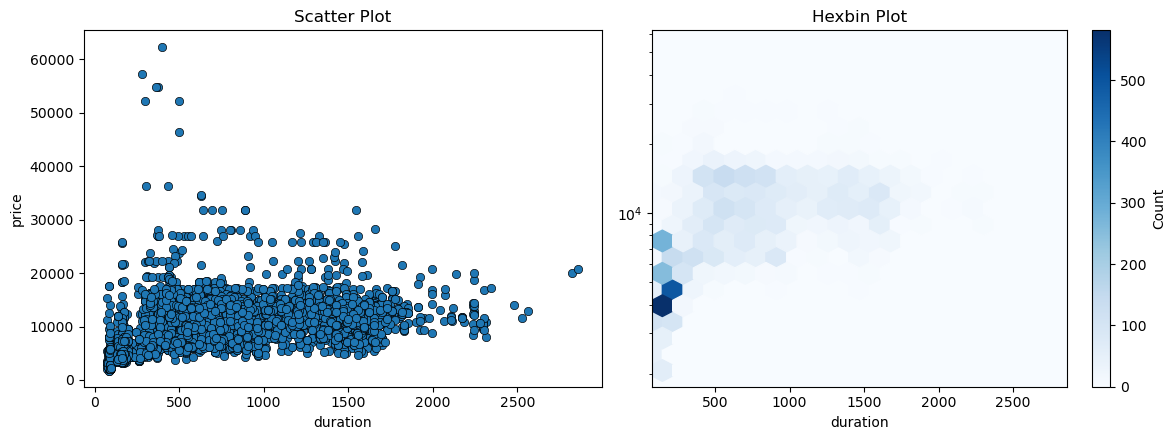

In [64]:
eda_helper_functions.num_bivar_plots(
    train,
    'duration',
    'price',
    hexbin_kwargs=dict(
        yscale='log',
        gridsize=20,
        cmap='Blues'
    )
)

In [65]:
eda_helper_functions.num_num_hyp_testing(
    train,
    'duration',
    'price'
)

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.5090124491778998
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables duration and price are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.6978600816697789
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables duration and price are correlated


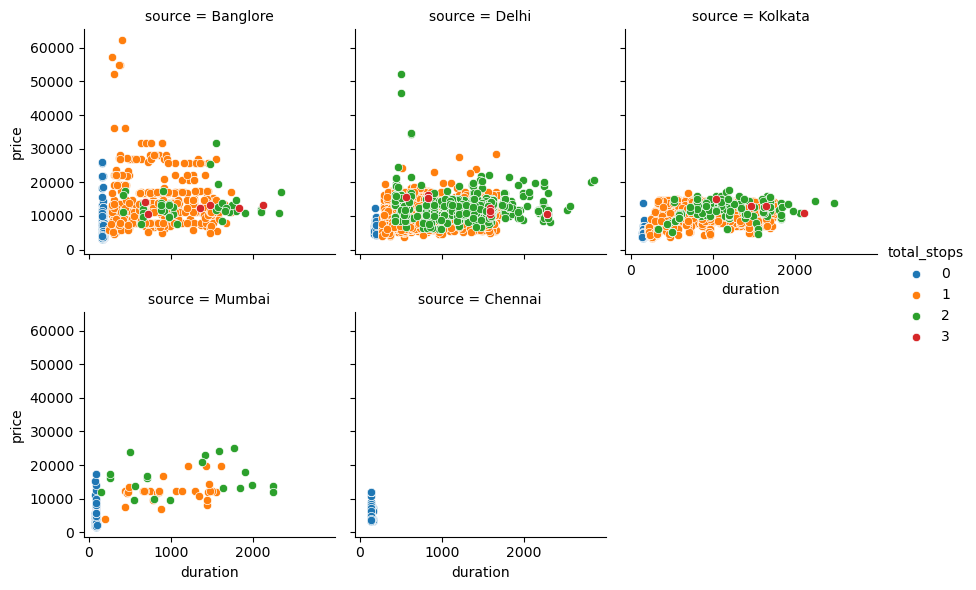

In [66]:
duration_grid = sns.FacetGrid(
    data=train,
    col='source',
    #row='additional_info',
    hue='total_stops',
    sharey=True,
    col_wrap=3
)

duration_grid.map(sns.scatterplot,'duration','price')
duration_grid.add_legend()

In [83]:
eda_helper_functions.get_iqr_outliers(train,'duration')

Lower Limit : -958.75
Upper Limit : 2051.25


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
3690,Air India,2019-05-01,Kolkata,Banglore,2024-06-12 05:50:00,2024-06-12 16:15:00,2065,2,No Info,10991
6079,Jet Airways,2019-03-06,Delhi,Cochin,2024-06-12 17:55:00,2024-06-12 04:25:00,2070,2,No Info,17072
3225,Jet Airways,2019-03-06,Delhi,Cochin,2024-06-12 17:55:00,2024-06-12 04:25:00,2070,2,In-Flight Meal Not Included,15812
2990,Air India,2019-03-03,Banglore,New Delhi,2024-06-12 11:05:00,2024-06-12 22:10:00,2105,2,No Info,11791
4589,Air India,2019-03-18,Banglore,New Delhi,2024-06-12 11:05:00,2024-06-12 22:10:00,2105,2,No Info,11161
1517,Air India,2019-03-03,Banglore,New Delhi,2024-06-12 11:05:00,2024-06-12 22:10:00,2105,2,No Info,11948
2916,Air India,2019-05-12,Kolkata,Banglore,2024-06-12 12:00:00,2024-06-12 23:15:00,2115,3,No Info,10991
2170,Air India,2019-03-12,Banglore,New Delhi,2024-06-12 06:45:00,2024-06-12 18:05:00,2120,3,No Info,13387
1105,Jet Airways,2019-03-06,Delhi,Cochin,2024-06-12 16:50:00,2024-06-12 04:25:00,2135,2,No Info,19907
4000,Air India,2019-03-06,Delhi,Cochin,2024-06-12 07:05:00,2024-06-12 19:15:00,2170,2,No Info,11552


### 8.8 total_stops

In [67]:
train['total_stops']=train['total_stops'].astype('object')

eda_helper_functions.cat_summary(train,'total_stops')

0       1
1       1
2       0
3       1
4       1
       ..
6690    2
6691    1
6692    1
6693    1
6694    1
Name: total_stops, Length: 6695, dtype: object

Data Type      : object
Cardinality    : 4 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,695 / 6,695 rows


,
count,6695
unique,4
top,1
freq,3580


,count,percentage
category,,
1,3580,0.534727
0,2232,0.333383
2,862,0.128753
3,21,0.003137


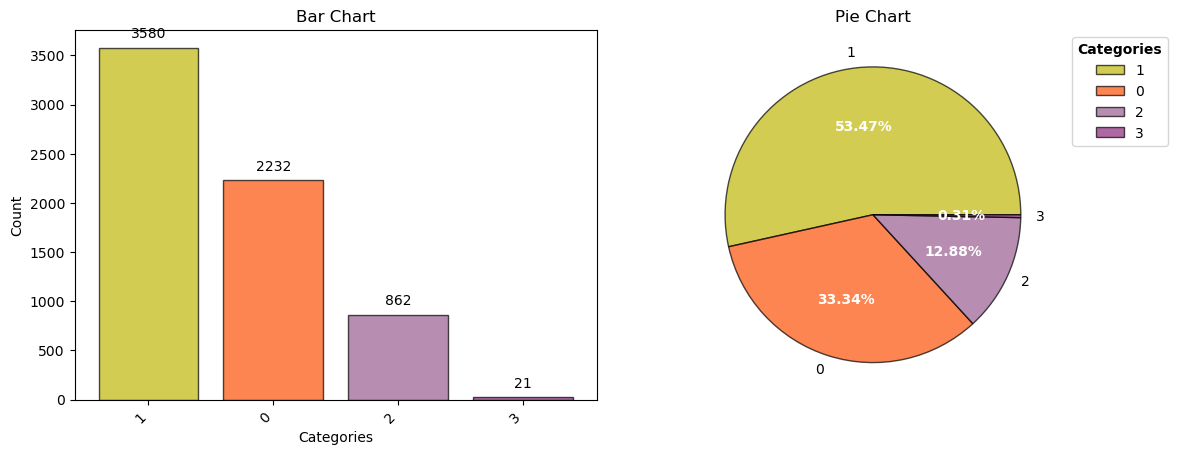

In [68]:
eda_helper_functions.cat_univar_plots(train,'total_stops',show_wordcloud=False)

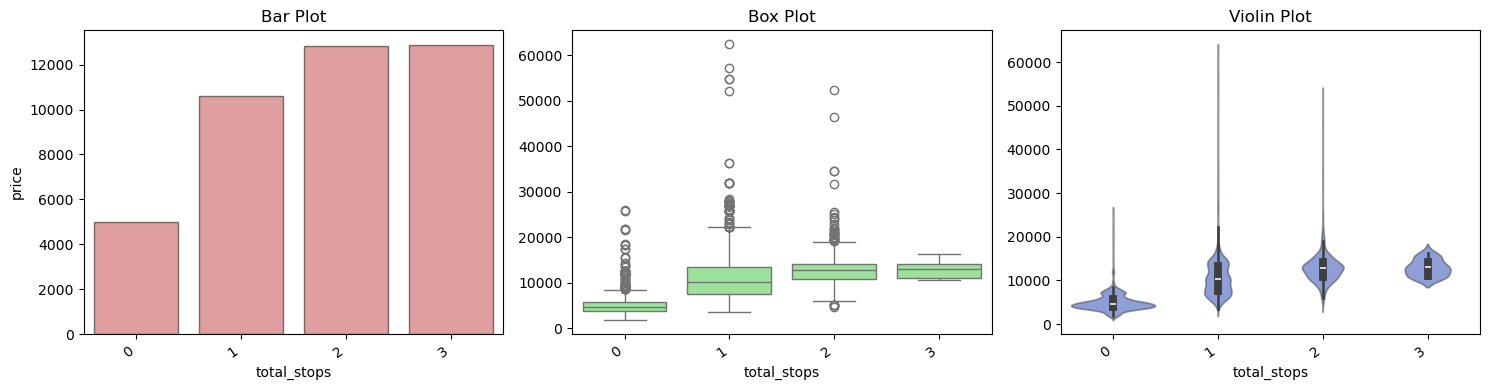

In [69]:
eda_helper_functions.num_cat_bivar_plots(
    data=train,
    num_var='price',
    cat_var='total_stops'
)

`CONCLUSION : `
- Direct flights are least expensive.
- As stops increases flight price also increases.

In [70]:
eda_helper_functions.num_cat_hyp_testing(train,'price','total_stops')

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 1499.8408375654367
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and total_stops are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 3638.891277319397
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and total_stops are associated to each other


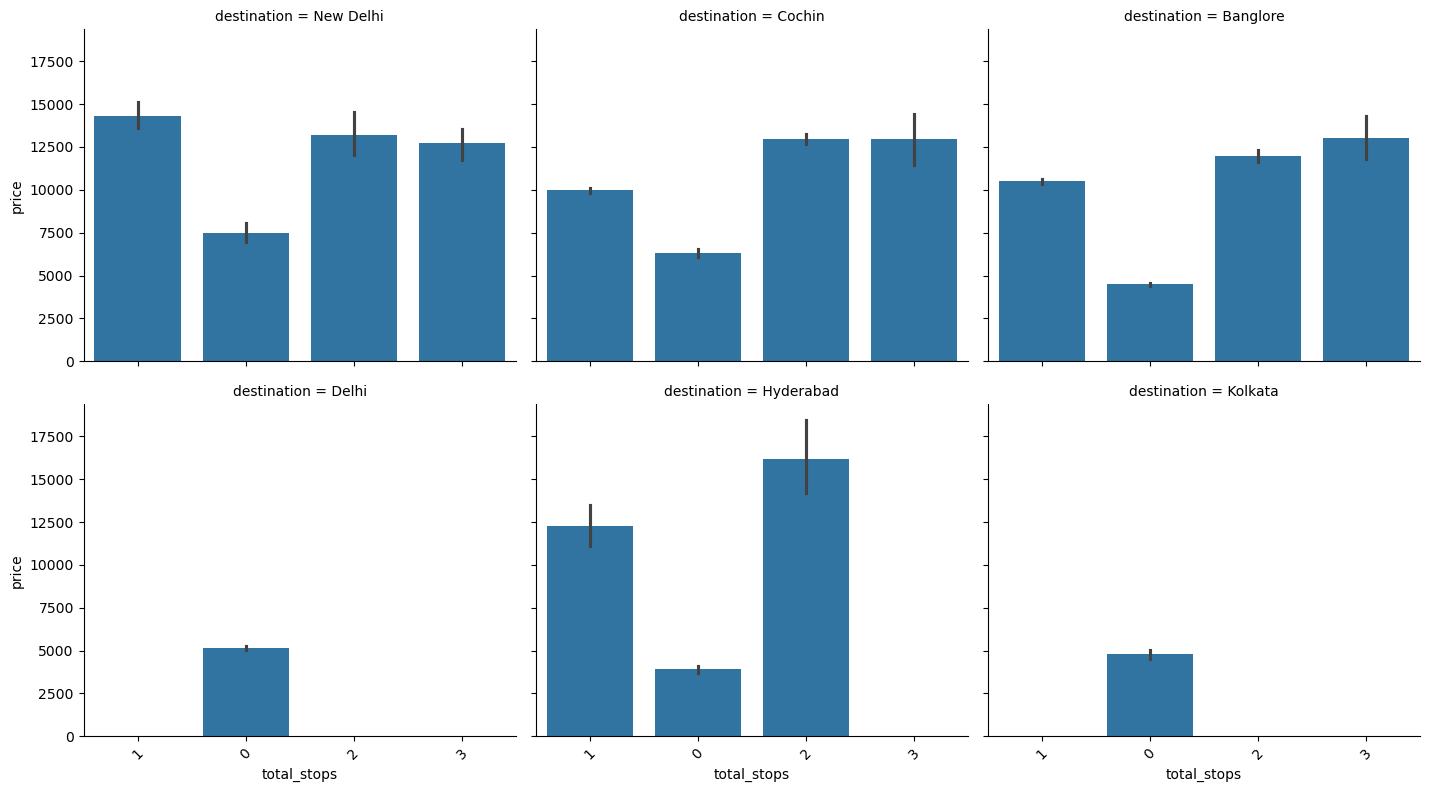

In [71]:
airline_grid = sns.FacetGrid(
    data=train,
    col='destination',
    col_wrap=3,
    height=4,
    aspect=1.2,
    sharey=True
)


airline_grid.map(
    sns.barplot,
    'total_stops',
    'price',
     order=train.total_stops.unique()
)

for ax in airline_grid.axes[3:]:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

### 8.9 additional_info

In [72]:
eda_helper_functions.cat_summary(train,'additional_info')

0       In-Flight Meal Not Included
1       In-Flight Meal Not Included
2                           No Info
3                           No Info
4       In-Flight Meal Not Included
                   ...             
6690                        No Info
6691                        No Info
6692    In-Flight Meal Not Included
6693                        No Info
6694                 1 Long Layover
Name: additional_info, Length: 6695, dtype: object

Data Type      : object
Cardinality    : 7 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,695 / 6,695 rows


,
count,6695
unique,7
top,No Info
freq,5249


,count,percentage
category,,
No Info,5249,0.784018
In-Flight Meal Not Included,1215,0.181479
No Check-In Baggage Included,207,0.030919
1 Long Layover,16,0.002390
Change Airports,5,0.000747
Business Class,2,0.000299
Red-Eye Flight,1,0.000149


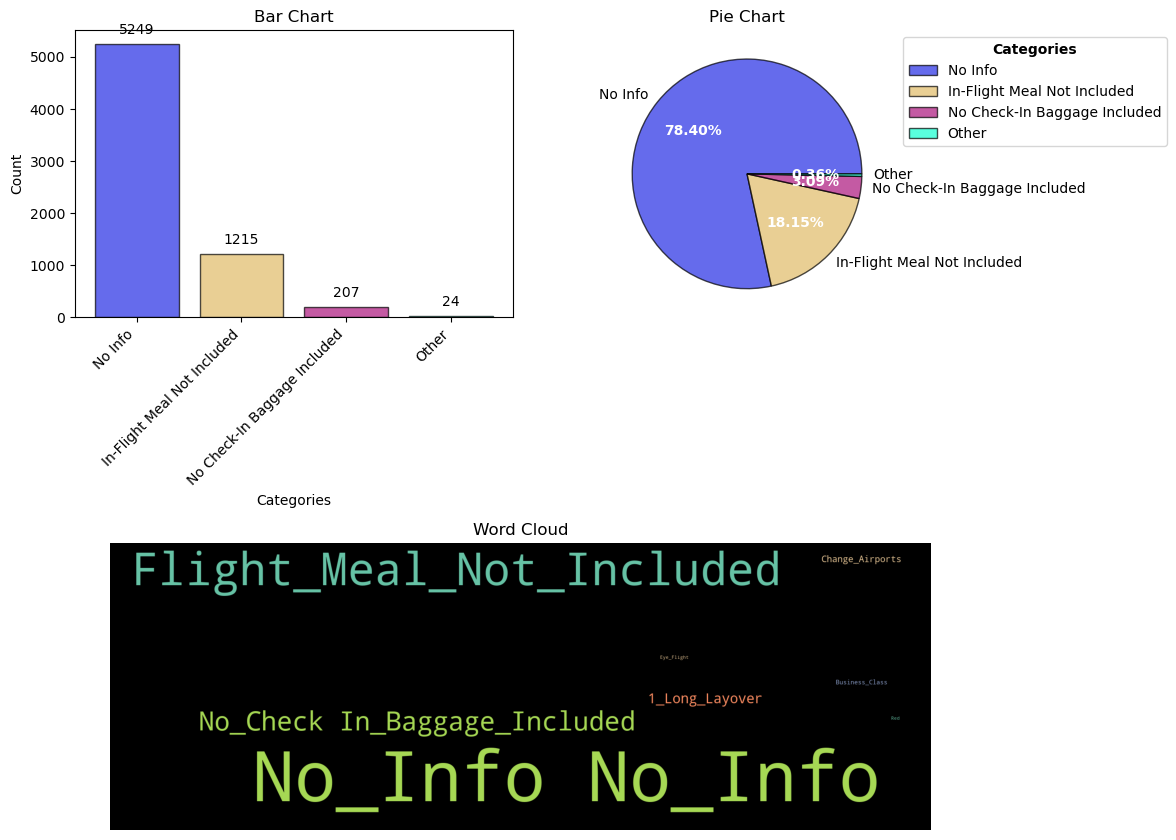

In [73]:
eda_helper_functions.cat_univar_plots(train,'additional_info',k=3)

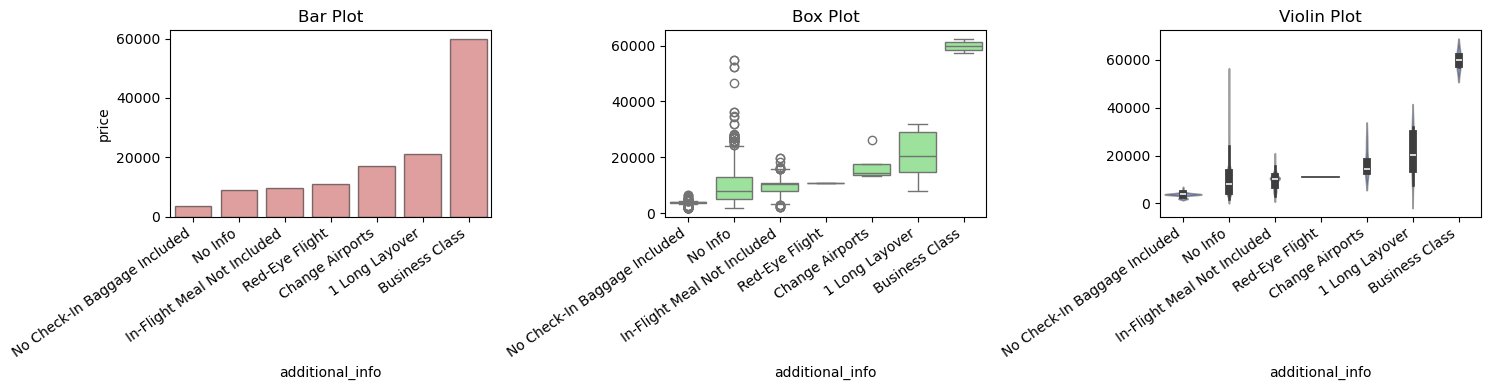

In [74]:
eda_helper_functions.num_cat_bivar_plots(
    data=train,
    num_var='price',
    cat_var='additional_info'
)

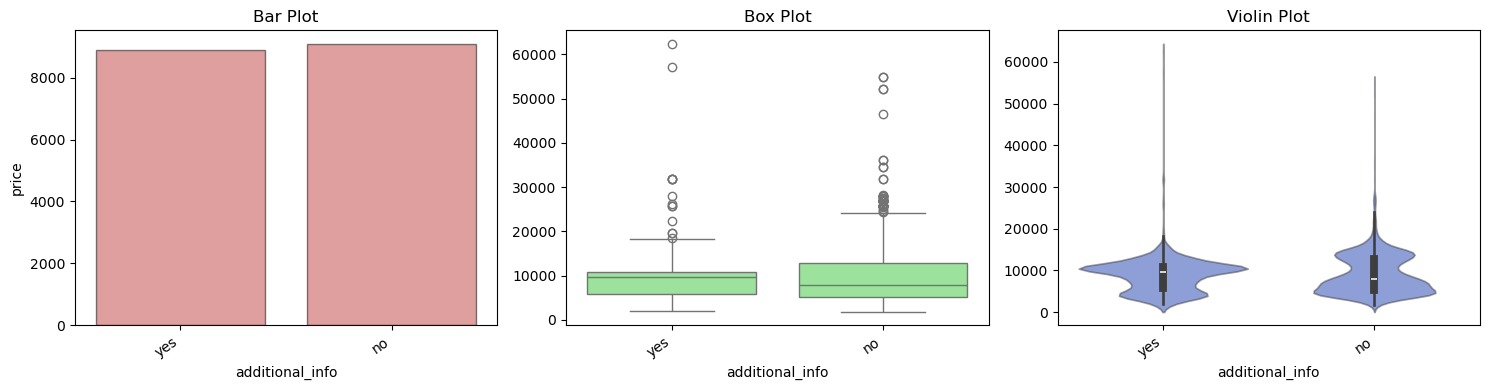

In [84]:
(
	train
	.assign(additional_info=(
		train
		.additional_info
		.pipe(lambda ser: np.where(ser.eq("No Info"), "no", "yes"))
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "additional_info")
)

`CONCLUSION : `

- Business class ticket is most expensive.
- additional_info has severely rare categories- 
Converted it into a binary feature for further analysis